# Import library

In [6]:
"""

Potential Field based path planner

author: Atsushi Sakai (@Atsushi_twi)

Ref:
https://www.cs.cmu.edu/~motionplanning/lecture/Chap4-Potential-Field_howie.pdf

"""

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import os

# Constant setting

In [7]:
# Parameters
KP = 5.0  # attractive potential gain
ETA = 100.0  # repulsive potential gain
AREA_WIDTH = 30.0  # potential area width [m]
#obstacle danger distances
MIN_DISTANCE = 3
# the number of previous positions used to check oscillations
OSCILLATIONS_DETECTION_LENGTH = 3

show_animation = True

# Potential method

In [8]:
def calc_potential_field(gx, gy, ox, oy, reso, rr, sx, sy):
    minx = min(min(ox), sx, gx) - AREA_WIDTH / 2.0
    miny = min(min(oy), sy, gy) - AREA_WIDTH / 2.0
    maxx = max(max(ox), sx, gx) + AREA_WIDTH / 2.0
    maxy = max(max(oy), sy, gy) + AREA_WIDTH / 2.0
    xw = int(round((maxx - minx) / reso))
    yw = int(round((maxy - miny) / reso))

    # calc each potential
    pmap = [[0.0 for i in range(yw)] for i in range(xw)]

    for ix in range(xw):
        x = ix * reso + minx

        for iy in range(yw):
            y = iy * reso + miny
            ug = calc_attractive_potential(x, y, gx, gy)
            uo = calc_repulsive_potential(x, y, ox, oy, rr)
            uf = ug + uo
            pmap[ix][iy] = uf

    return pmap, minx, miny


def calc_attractive_potential(x, y, gx, gy):
    return 0.5 * KP * np.hypot(x - gx, y - gy)  # np.hypot() ~ square(x**2+y**2)


def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 0.1:
            dq = 0.1

        return 0.5 * ETA * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0

# Utility
- motion setting 
- oscillation detection
- draw heatmap

In [9]:
def get_motion_model():
    # dx, dy
    motion = [[1, 0], [0, 1], [-1, 0], [0, -1], [-1, -1], [-1, 1], [1, -1], [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH:
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False


def draw_heatmap(data, count,saveDir):
    data = np.array(data).T
    plt.pcolor(data, vmax=100.0, cmap=plt.cm.Blues)
    saveFig = os.path.join(saveDir, f"headMap_{count}.jpg")
    plt.savefig(saveFig)

# planning based on potential field

In [15]:
def potential_field_planning(sx, sy, sx_init,sy_init,gx, gy, ox, oy, reso, rr, count,saveDir):
    """potential field planning

    Args:
        sx (float): current position x
        sy (float): current position y
        sx_init (float): initial position x
        sy_init (float): initial position y
        gx (float): goal position x
        gy (float): goal position y
        ox (float): obstacle position x
        oy (float): obstacle position y
        reso (float): map resolution
        rr (): _description_
        saveDir (string): save directory
    """
    # calc potential field of whole map
    pmap, minx, miny = calc_potential_field(gx, gy, ox, oy, reso, rr, sx_init, sy_init)

    # search path
    ix = round((sx - minx) / reso) #initial position in grid cell coordinate
    iy = round((sy - miny) / reso) 
    gix = round((gx - minx) / reso) #goal position in grid cell coordinates
    giy = round((gy - miny) / reso)

    if show_animation:
        draw_heatmap(pmap, count,saveDir)
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            "key_release_event",
            lambda event: [exit(0) if event.key == "escape" else None],
        )
        plt.plot(ix, iy, "*k")
        plt.plot(gix, giy, "*m")

    rx, ry = [sx], [sy]
    motion = get_motion_model()
    previous_ids = deque()
    return pmap,minx,miny,ix,iy,rx,ry,motion,previous_ids

def motionPlanning(sx,sy,reso,rr,gx,gy,ox,oy,saveDir):
    """motion planning module

    Returns:
        motion(list): list of motion options
        reso(float) : minimum resolution of map
        rr (): _description_
        d : distance between current position and goal position
        ix(float) : initial position x
        iy(float) : initial position y
        gx (float): goal position x
        gy (float): goal position y
        ox (float): obstacle position x
        oy (float): obstacle position y
        rx(list) : route position x
        ry(list) : route position y
        minx(float) : left
        miny(float) : bottom
        previous_ids(float) : previous ids
        pmap : potential map 
        saveDir (string): save directory
    """
    colors = ["r","g","b","c","m","y","k"]
    count_replan = 0
    sx_init=sx #initial position
    sy_init = sy #initial position
    d = np.hypot(sx - gx, sy - gy)
    pmap,minx,miny,ix,iy,rx,ry,motion,previous_ids = potential_field_planning(sx=sx, sy=sy, sx_init=sx_init,sy_init=sy_init,gx=gx, gy=gy, ox=ox[0], oy=oy[0], reso=reso, rr=rr, count=count_replan,saveDir=saveDir)
    counter = 0
    xp=rx[0]
    yp=ry[0]
    counter_avoid=0
    routes = dict()
    while d >= reso:
        distances = []
        #check distance between obstacle and calculation position
        for px,py in zip(ox[counter%len(ox)],oy[counter%len(ox)]):
            distances.append(np.hypot(xp-px, yp-py))
        min_distances = min(distances)
        print(min_distances)
        #replan motion path
        if min_distances < MIN_DISTANCE and counter_avoid<=0:
            print("replan path")
            count_replan += 1
            pmap,minx,miny,ix,iy,_, _, _, previous_ids = potential_field_planning(sx=xp, sy=yp, sx_init=sx_init,sy_init=sy_init,gx=gx, gy=gy, ox=ox[counter%len(ox)], oy=oy[counter%len(oy)], reso=reso, rr=rr, count=count_replan,saveDir=saveDir)
            counter_avoid =10
        elif min_distances < MIN_DISTANCE and counter_avoid>0:
            counter_avoid-=1
        fig, ax = plt.subplots(figsize=(10, 10))
        minp = float("inf")
        minix, miniy = -1, -1
        #calculate potential difference among all motion options
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if inx >= len(pmap) or iny >= len(pmap[0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[inx][iny]
            if minp > p:
                minp = p
                minix = inx #best option in x
                miniy = iny #best option in y
        ix = minix #next position in x in grid cell coordinates 
        iy = miniy #next position in y in grid cell coordinates
        xp = ix * reso + minx #position in x in world coordinates
        yp = iy * reso + miny #position in y in world coordinates
        d = np.hypot(gx - xp, gy - yp) #calculate distance to goal
        rx.append(xp)
        ry.append(yp)

        if oscillations_detection(previous_ids, ix, iy):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break

        #plot path planning
        if show_animation:
            ax.plot(
                rx,
                ry,
                linestyle=" ",
                color=colors[count_replan%7],
                marker="o",
                markersize=4,
                label="agent",
            )
            ax.plot(gx, gy, color="b", marker="D", markersize=8, label="goal")
            ax.plot(
                ox[counter%len(ox)],
                oy[counter%len(oy)],
                color="k",
                linestyle=" ",
                marker="x",
                markersize=6,
                label="obstacle",
            )
            ax.set_xlim(0, 50)
            ax.set_ylim(0, 50)
            ax.set_title(f"{counter:03d}")
            ax.legend()
            filename = os.path.join(saveDir, f"{counter:03d}.jpg")
            fig.savefig(filename)
        counter += 1

    print("Goal!!")

    return rx, ry

# Main function

In [16]:
def dynamic_obatacles(coef_wrist):
    dx_wrist_elbow = []
    for i in range(40):
        if i<10:
            dx_wrist_elbow.append(coef_wrist/10*i)
        elif i>=10 and i<20:
            dx_wrist_elbow.append(-coef_wrist/10*(i-20))
        elif i>=20 and i<30:
            dx_wrist_elbow.append(coef_wrist/10*(i-20))
        elif i>=30 and i<40:
            dx_wrist_elbow.append(-coef_wrist/10*(i-40))
    return dx_wrist_elbow

def main(saveDir):
    print("potential_field_planning start")

    sx = 0.0  # start x position [m]
    sy = 10.0  # start y positon [m]
    gx = 30.0  # goal x position [m]
    gy = 30.0  # goal y position [m]
    grid_size = 0.5  # potential grid size [m]
    robot_radius = 5.0  # robot radius [m]

    ox = [15.0, 5.0, 20.0]  # obstacle x position list [m]
    oy = [25.0, 15.0, 26.0]  # obstacle y position list [m]
    coef_wrist=5
    coef_elbow=5
    coef_shoulder = 2.5
    obstacles_x = []
    obstacles_y = []
    d_wrist = dynamic_obatacles(coef_wrist=coef_wrist)
    #print(d_wrist)
    d_elbow = dynamic_obatacles(coef_wrist=coef_elbow)
    d_shoulder = dynamic_obatacles(coef_wrist=coef_shoulder)
    for i in range(len(d_wrist)):
        temp_x = []
        temp_y = []
        print(temp_x)
        for j in range(3):
            if j == 0:
                temp_x.append(ox[j]+d_wrist[i])
                temp_y.append(oy[j]+d_wrist[i])
            elif j==1:
                temp_x.append(ox[j]+d_elbow[i])
                temp_y.append(oy[j]+d_elbow[i])
            elif j==2:
                temp_x.append(ox[j]+d_shoulder[i])
                temp_y.append(oy[j]+d_shoulder[i])
        obstacles_x.append(temp_x)
        #print(obstacles_x)
        obstacles_y.append(temp_y)
    #print(obstacles_x)


    if show_animation:
        plt.grid(True)
        plt.axis("equal")

    # path generation
    motionPlanning(sx=sx,sy=sy,reso=grid_size,rr=robot_radius,gx=gx,gy=gy,ox=obstacles_x,oy=obstacles_y,saveDir=saveDir)

    if show_animation:
        plt.show()

potential_field_planning start
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.810249675906654
8.602325267042627
9.013878188659973
9.433981132056603
8.5
7.615773105863909
6.324555320336759
5.0990195135927845
4.0
3.1622776601683795
2.8284271247461903
replan path
3.1622776601683795
4.0
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845


C:\Users\kawaw\AppData\Local\Temp\ipykernel_4168\4003179683.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 10))


5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845
6.324555320336759
7.615773105863909
6.324555320336759
5.0990195135927845
4.0
3.1622776601683795
2.8284271247461903
2.5
2.3717082451262845
2.0
2.7613402542968153
3.0413812651491097
2.850438562747845
3.1622776601683795
3.020761493398643
2.9154759474226504
2.850438562747845
2.8284271247461903
2.850438562747845
2.9154759474226504
replan path
3.3354160160315836
4.0
4.808846015417836
5.70087712549569
6.642665127793212
7.615773105863909
8.403868156985805
9.192388155425117
9.981232388838565
Goal!!


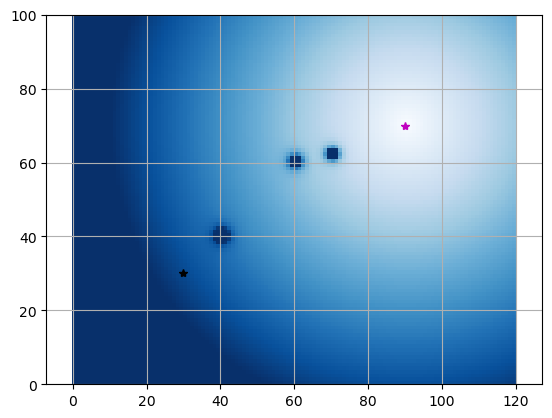

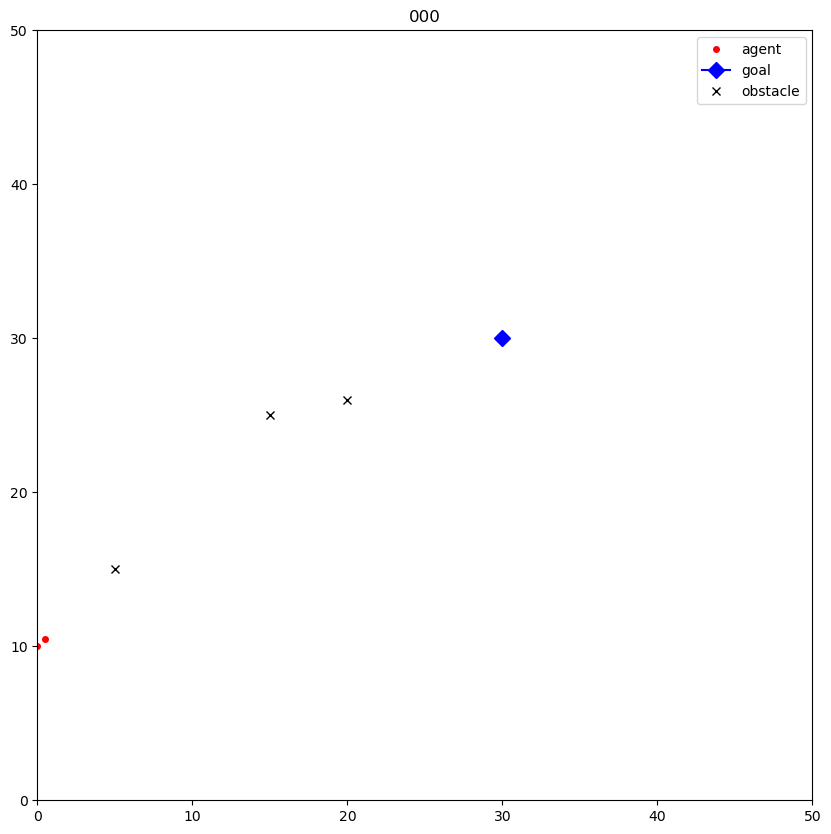

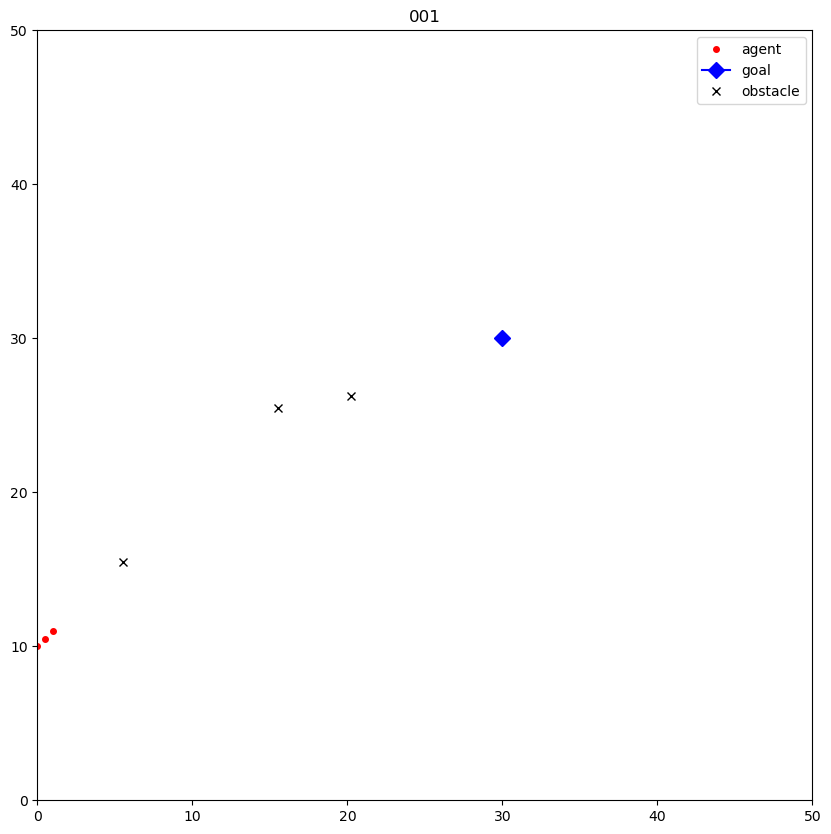

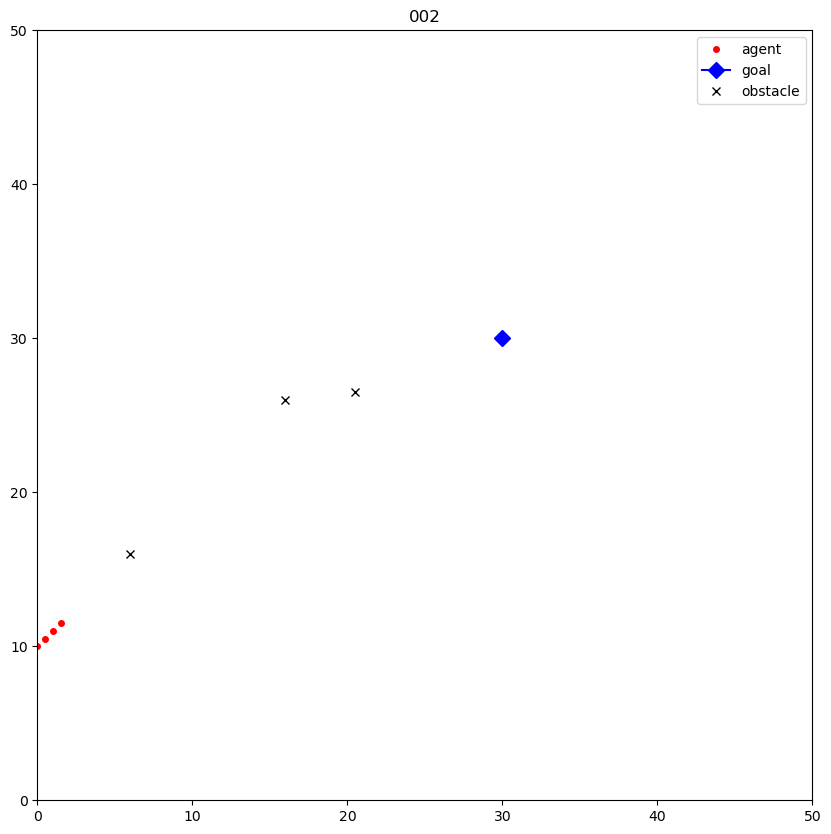

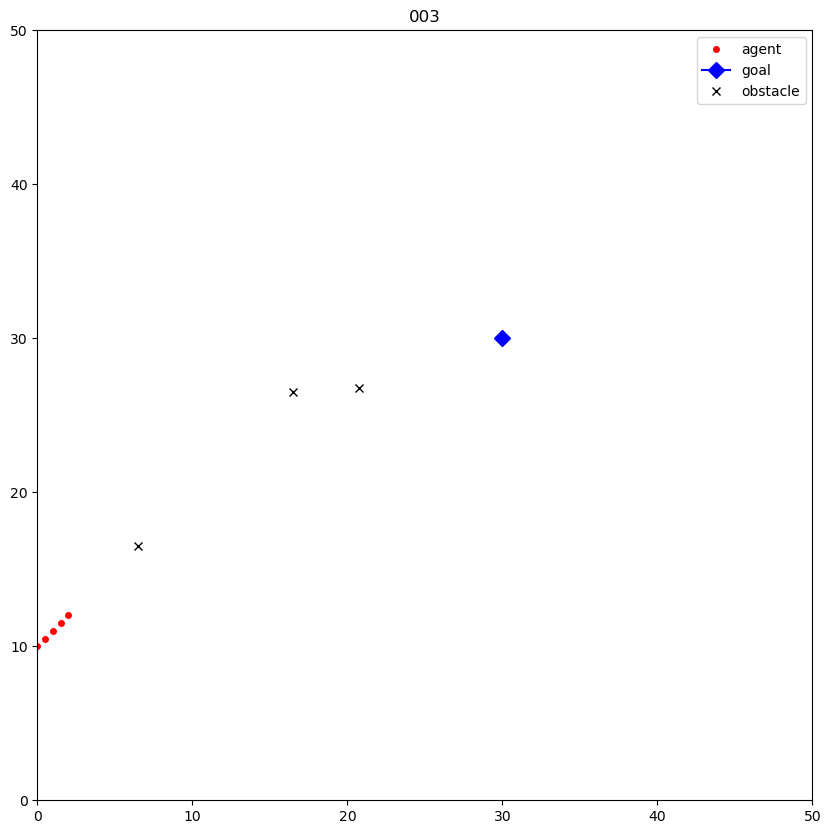

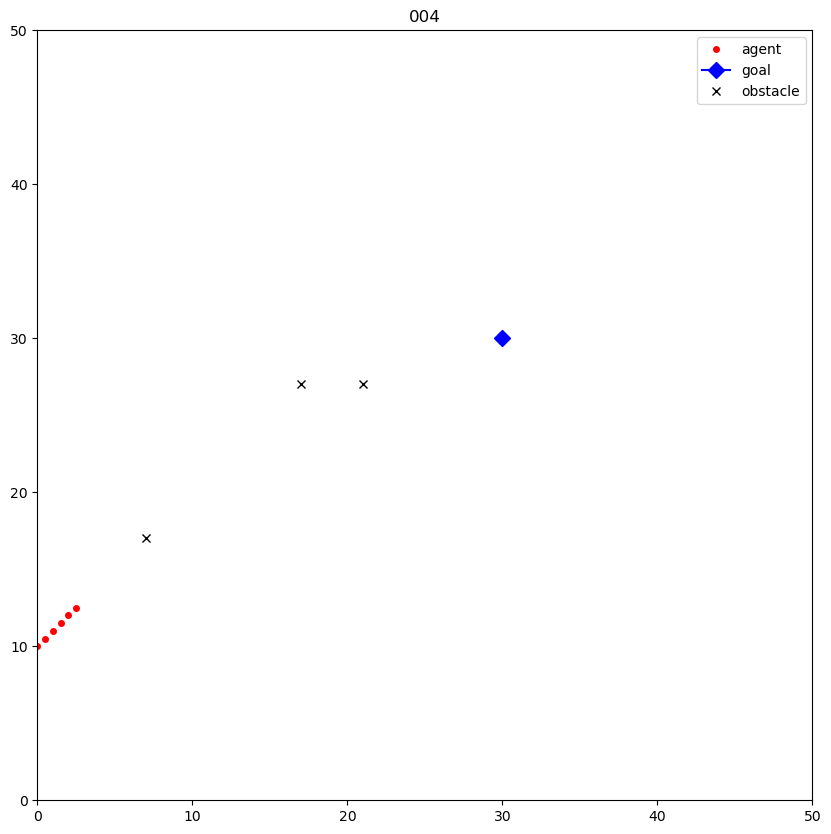

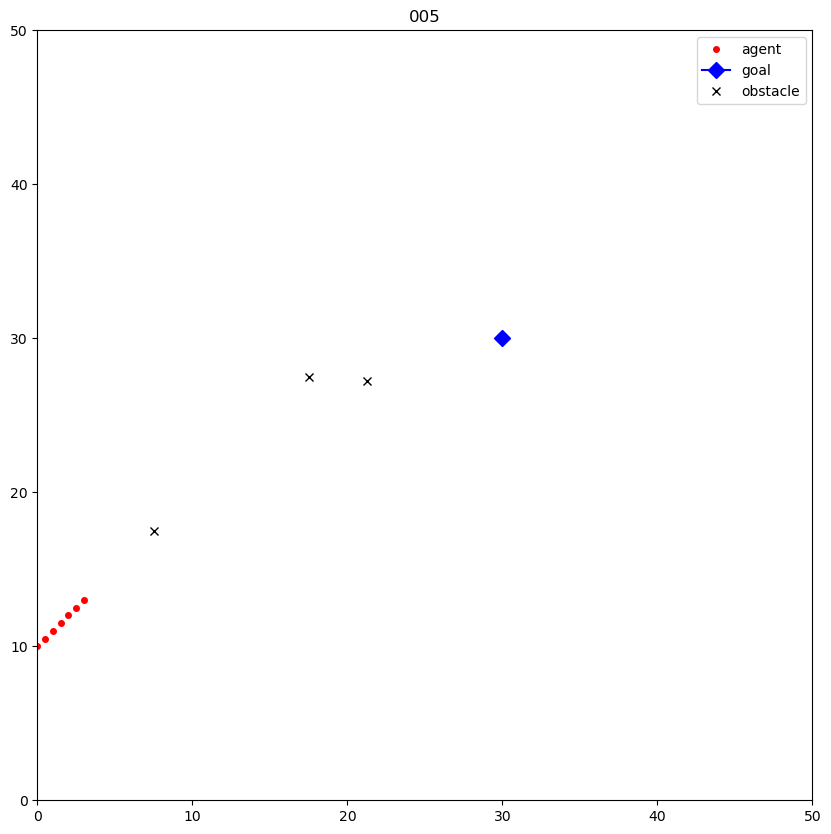

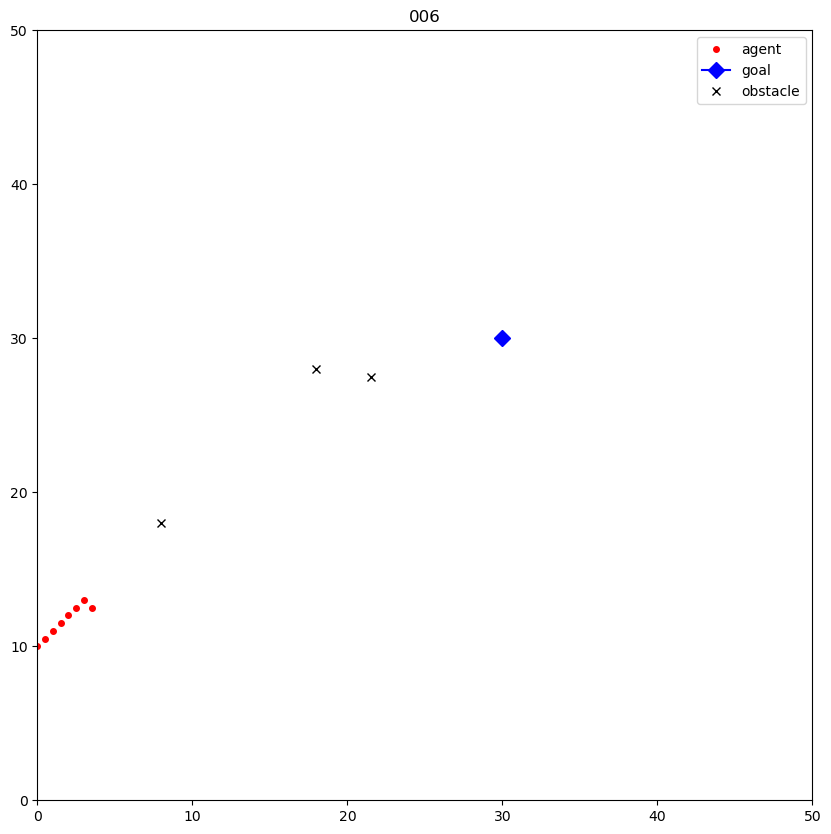

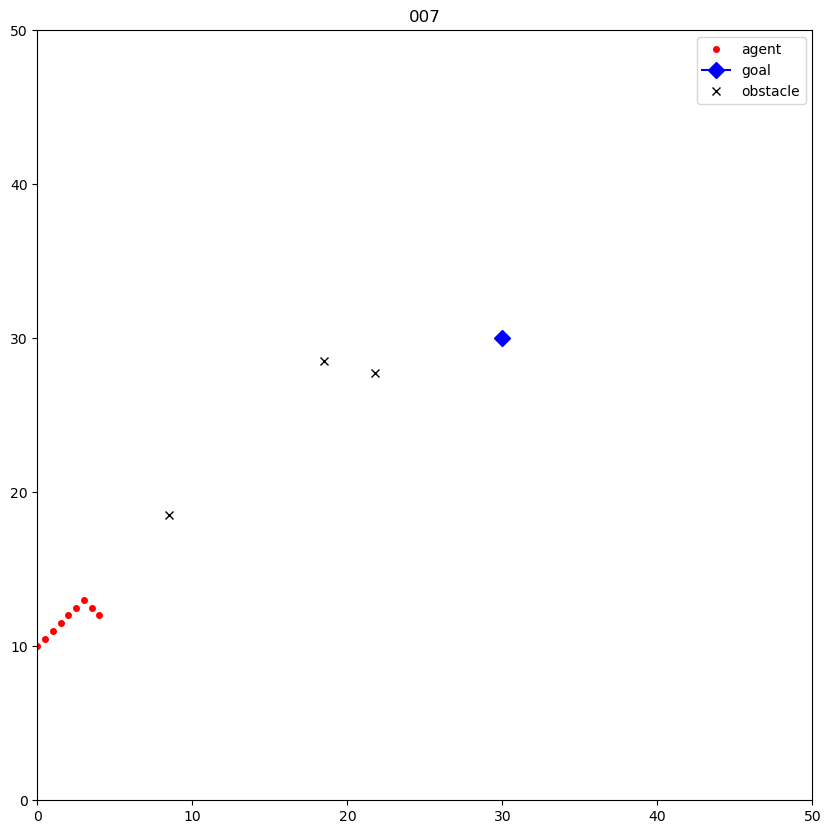

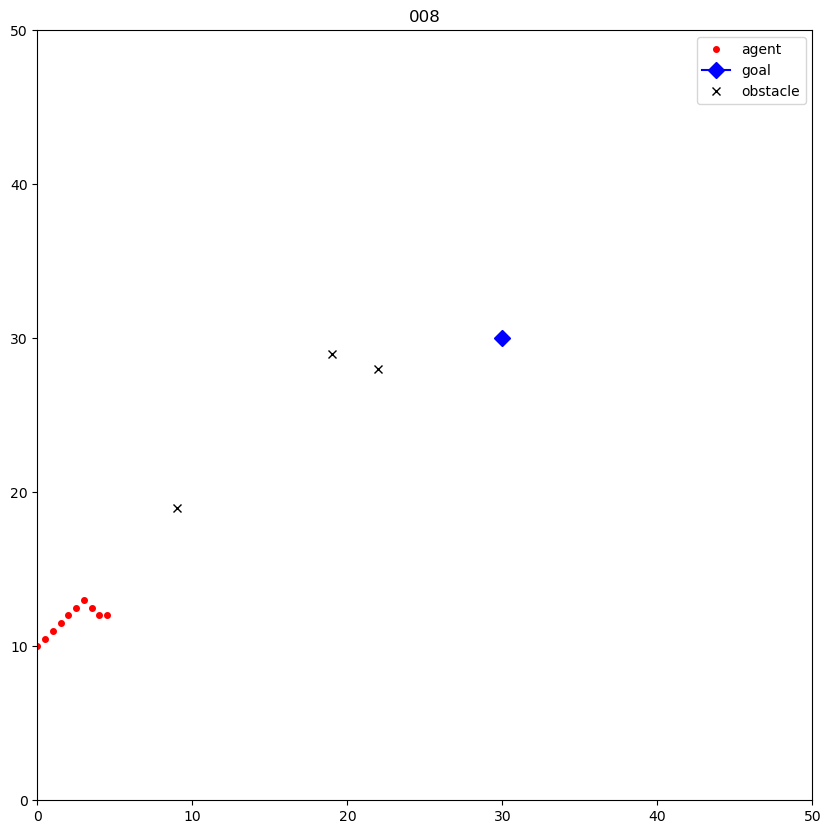

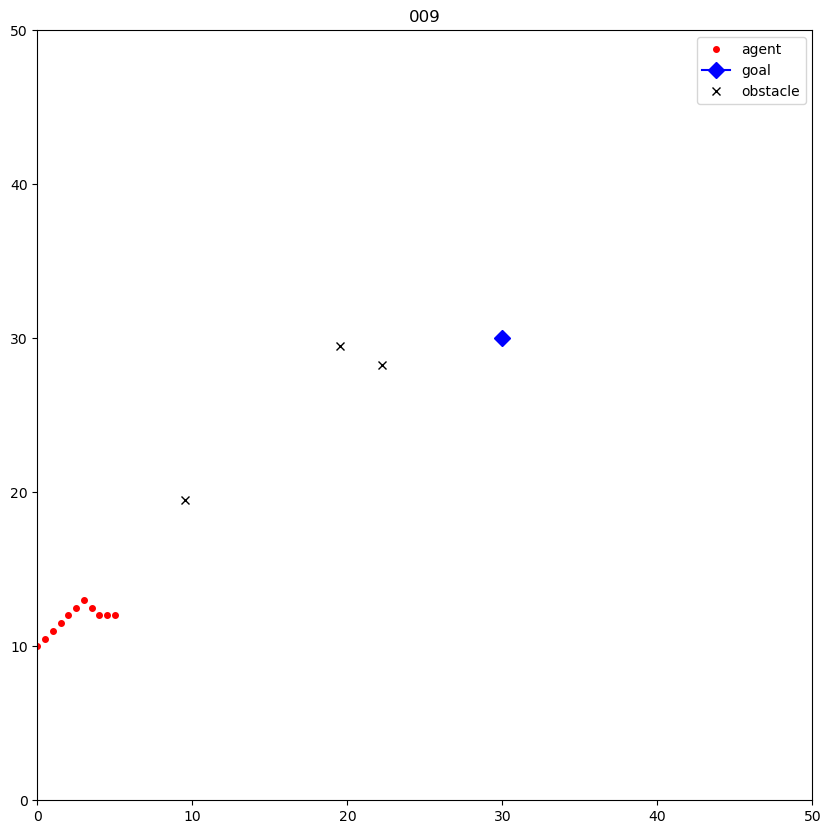

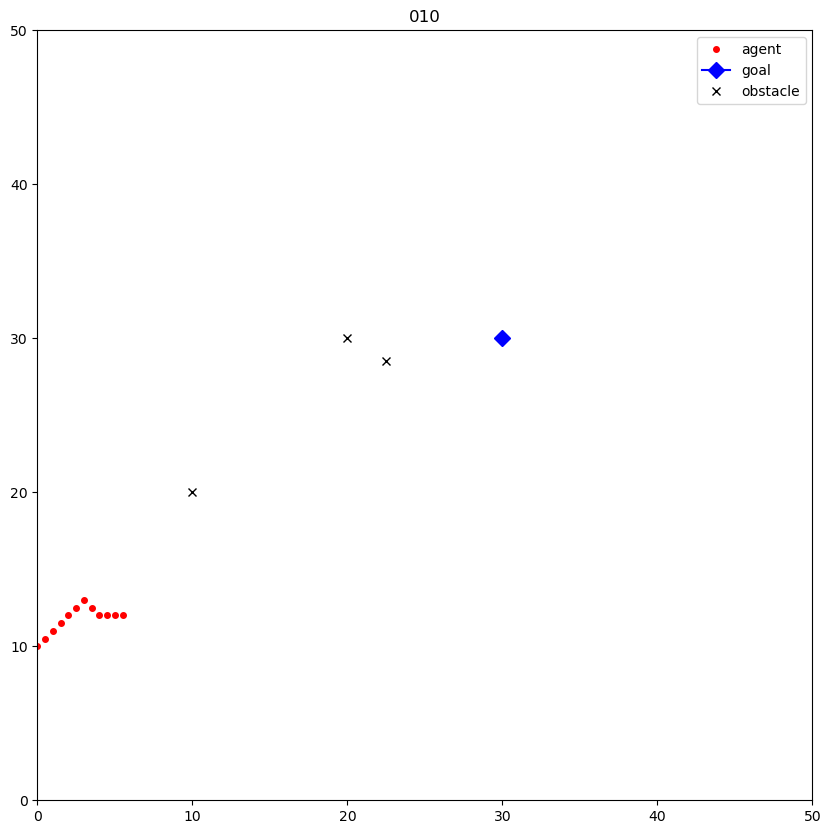

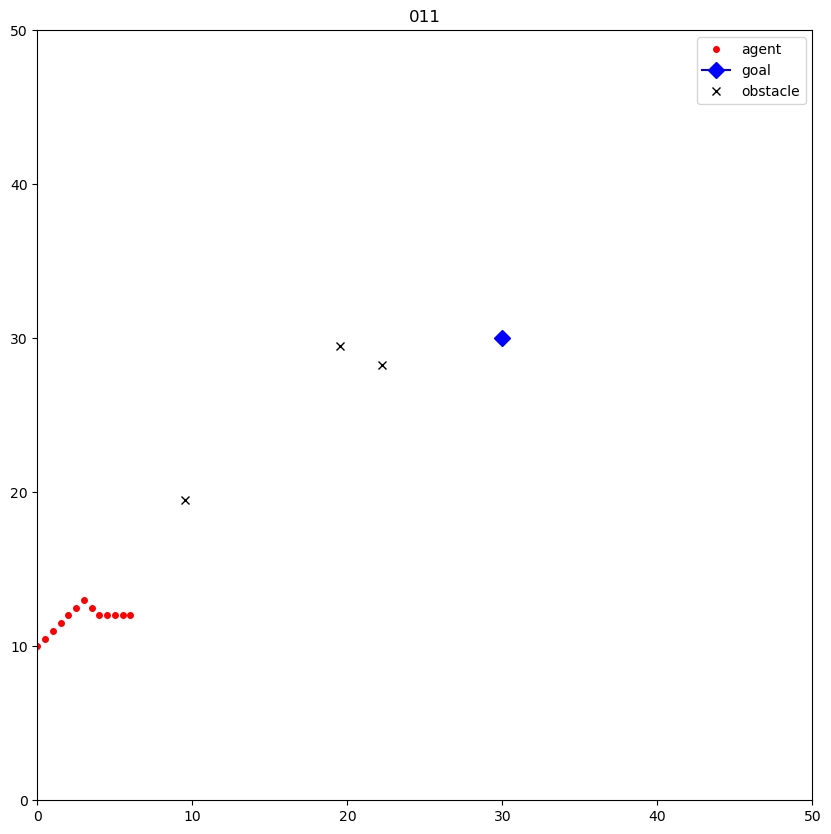

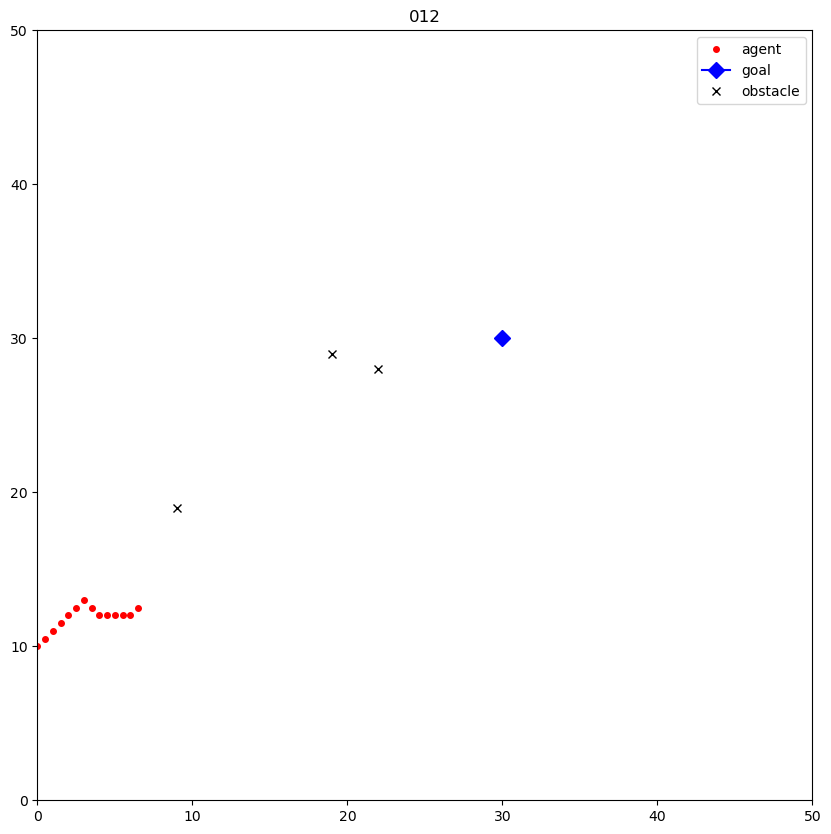

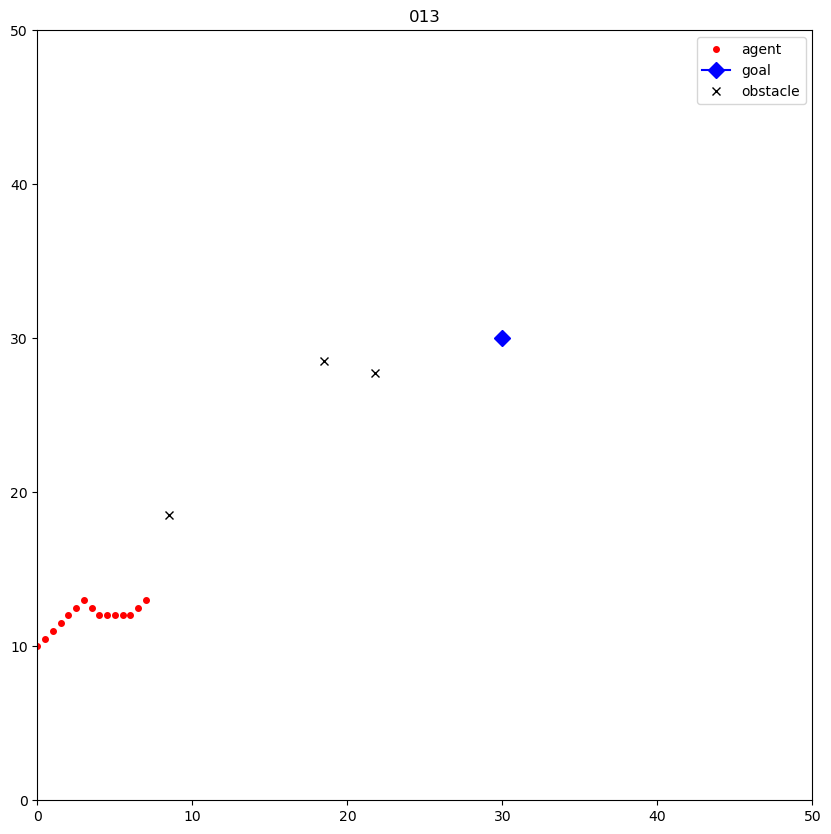

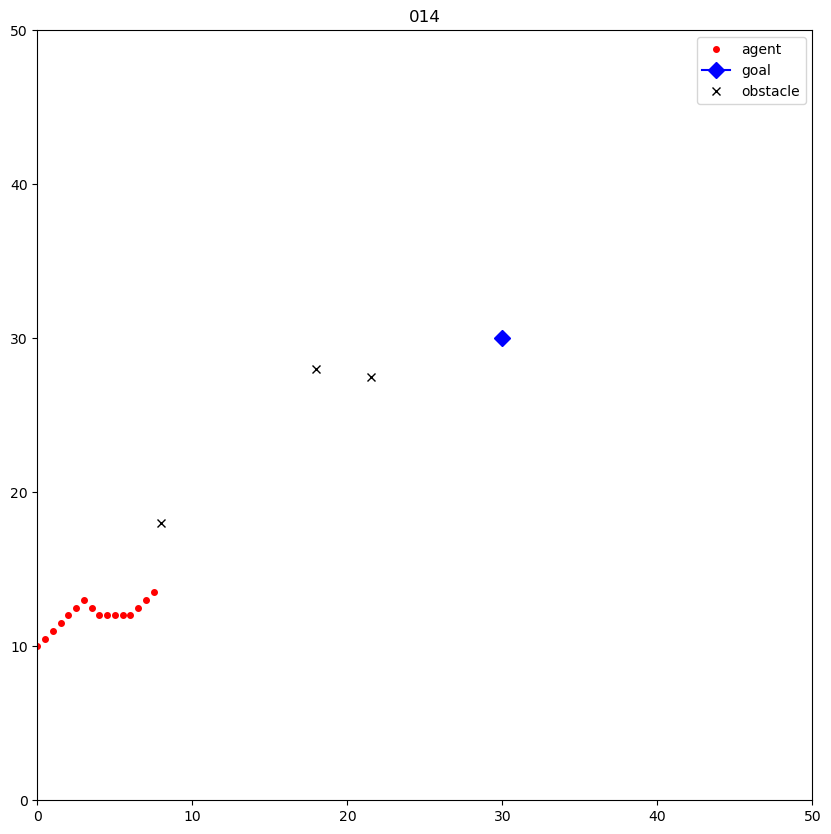

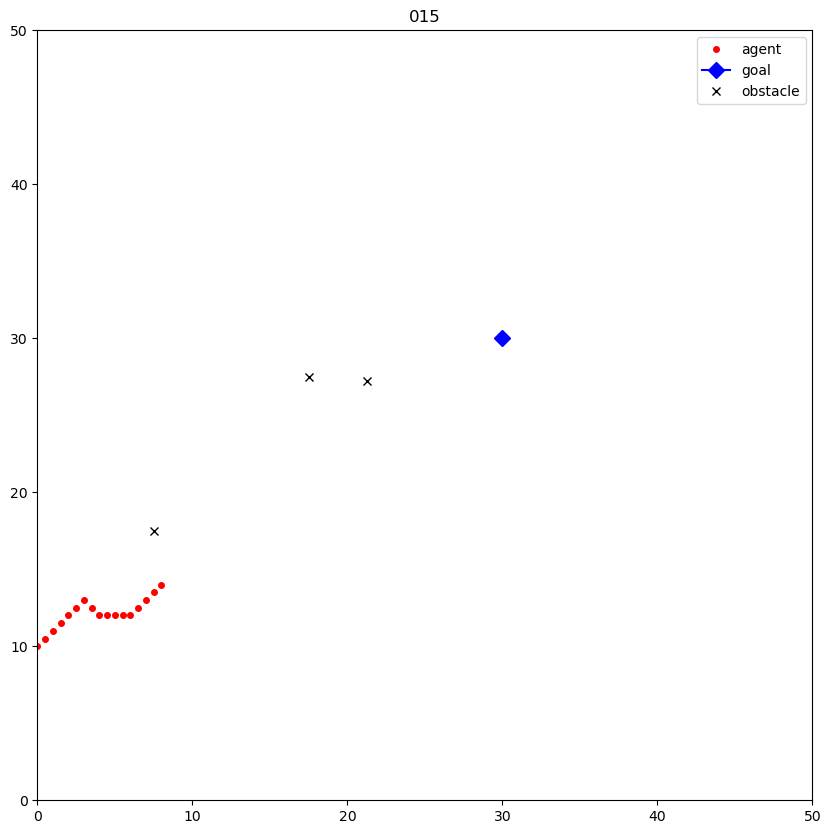

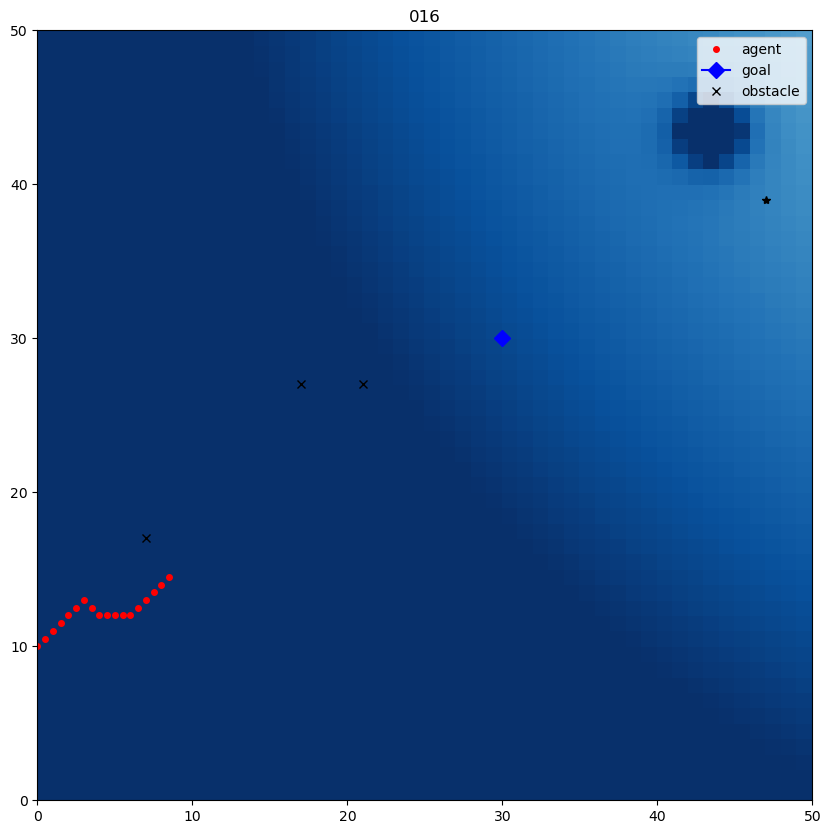

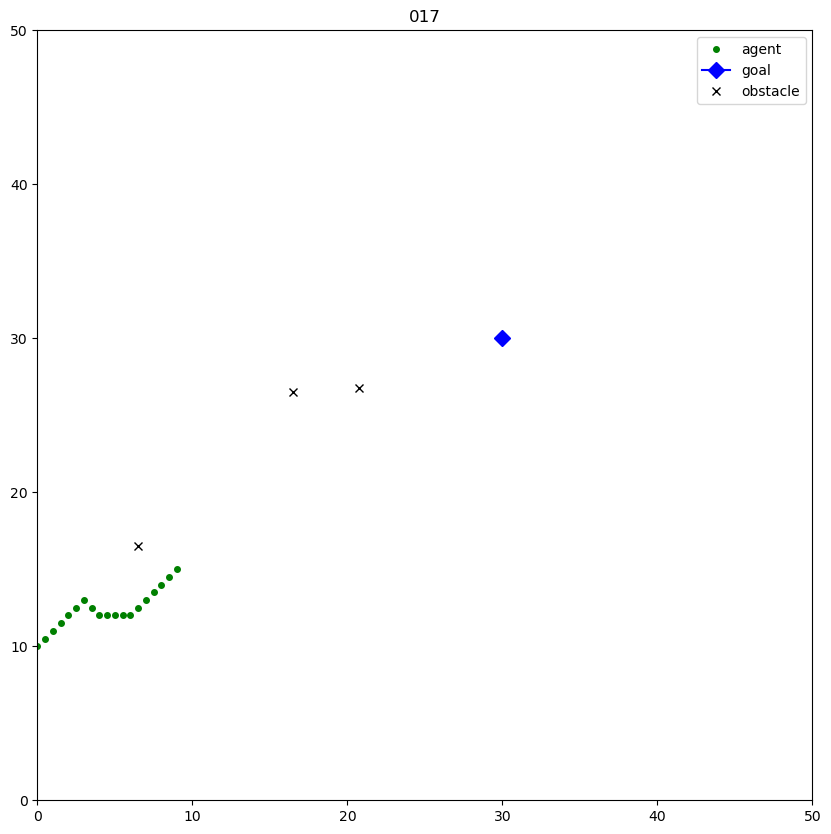

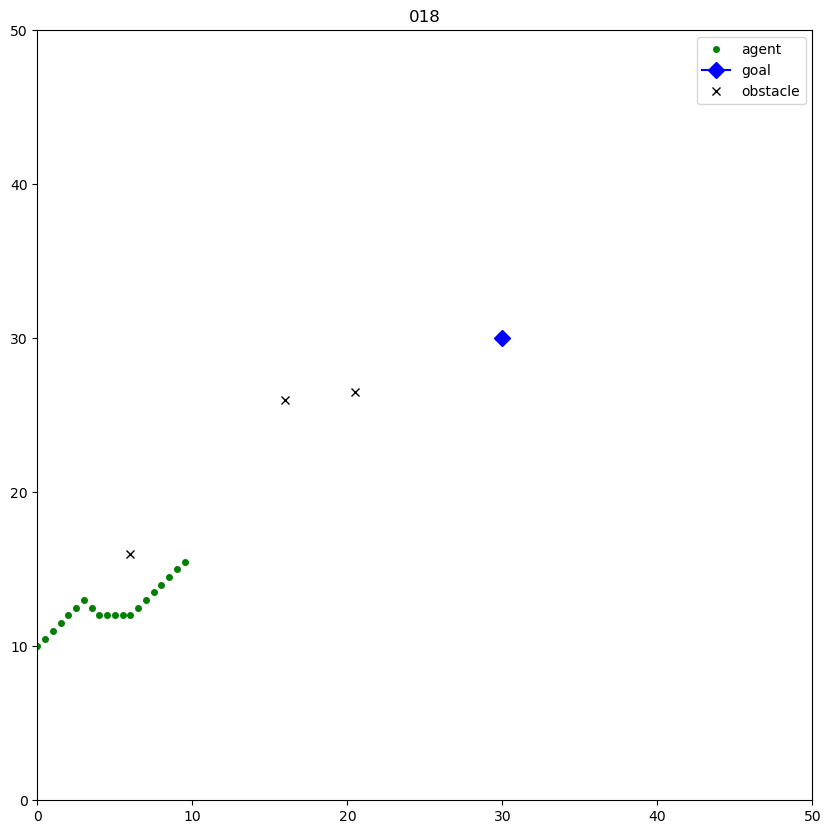

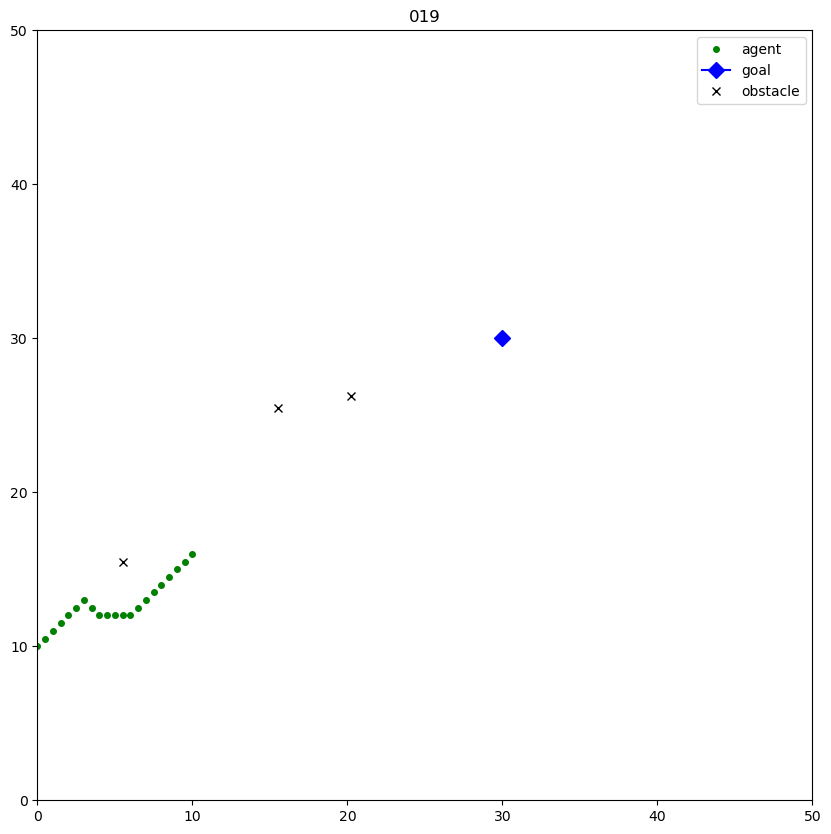

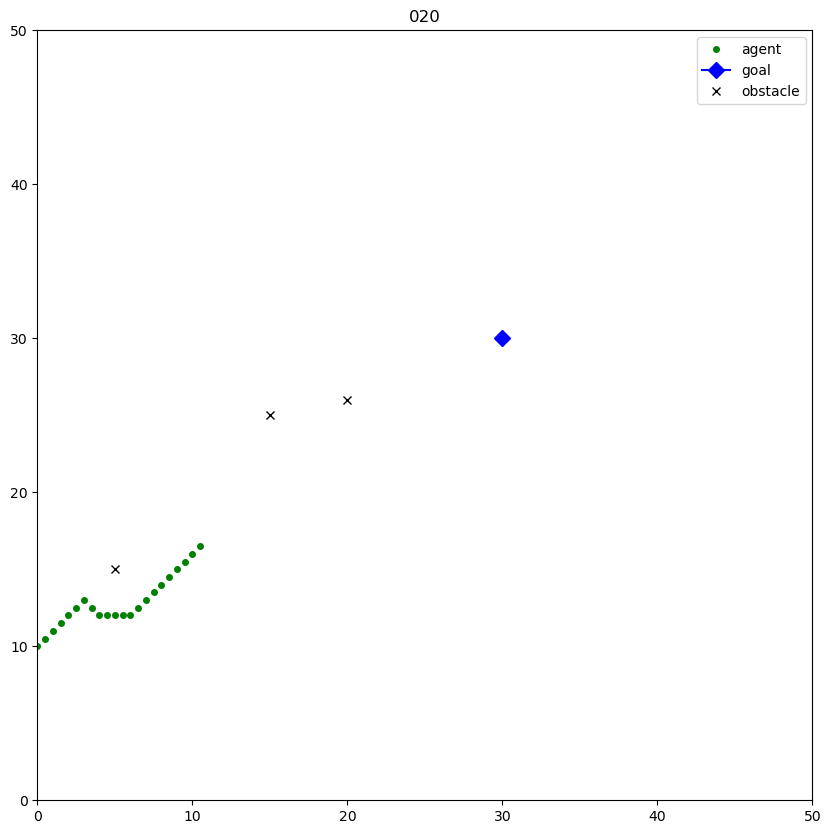

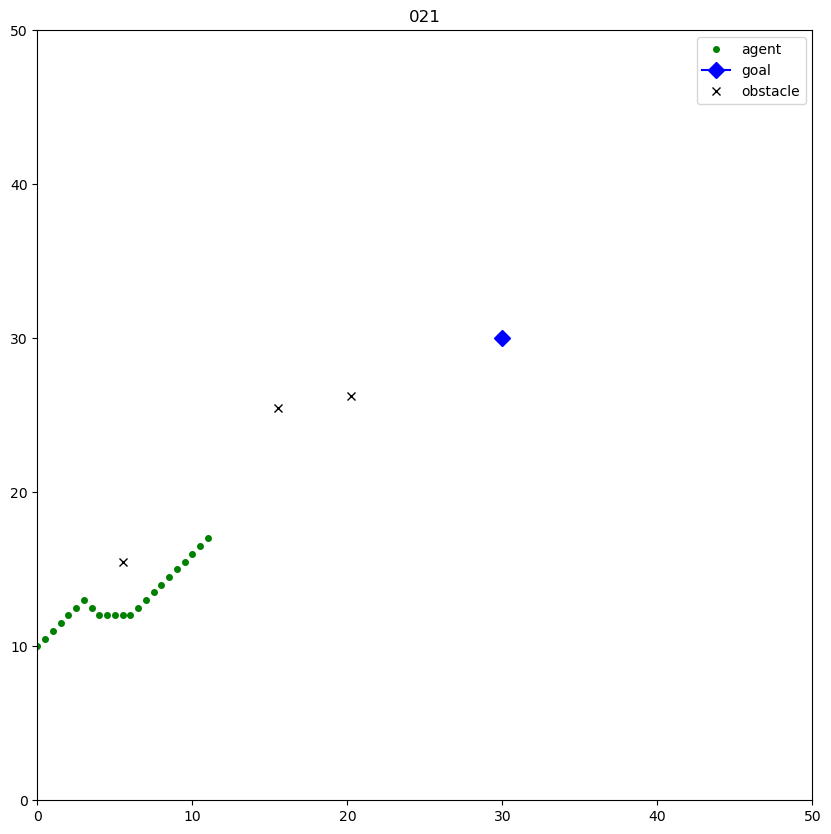

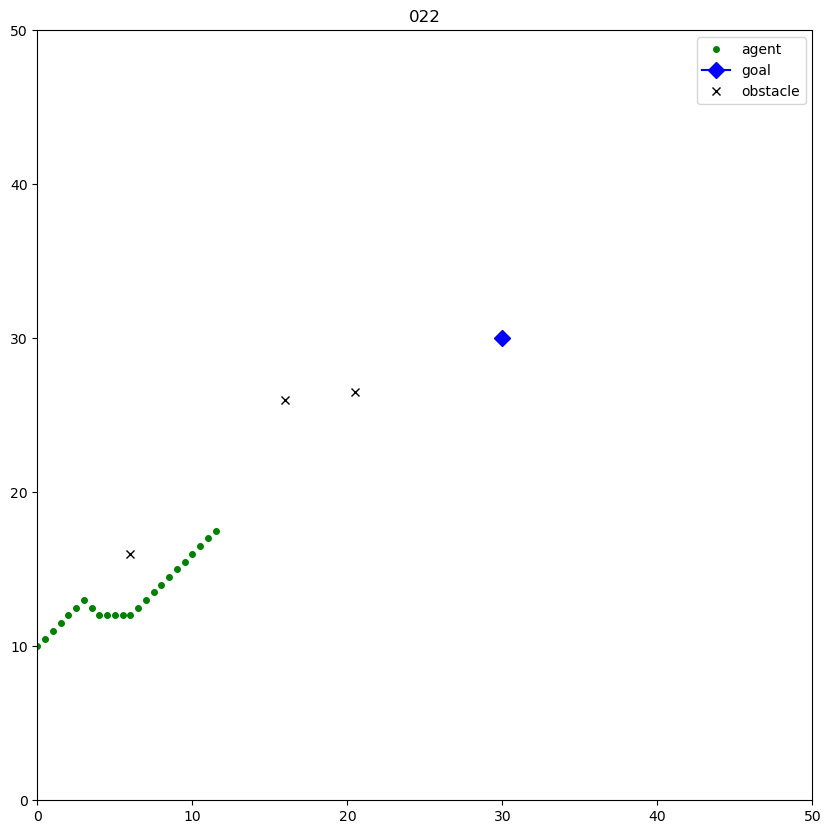

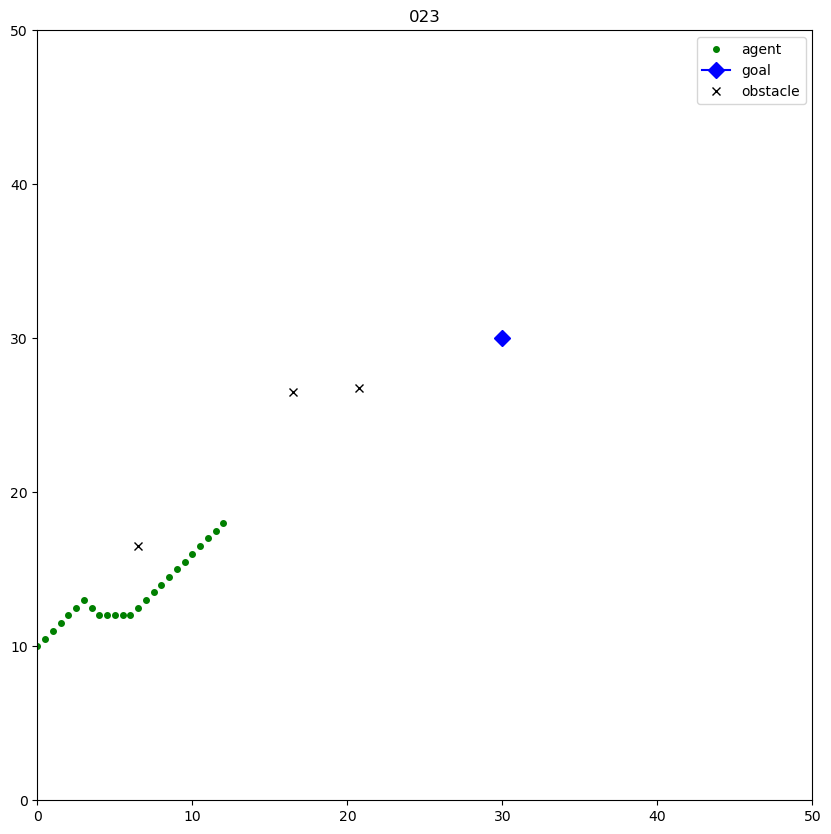

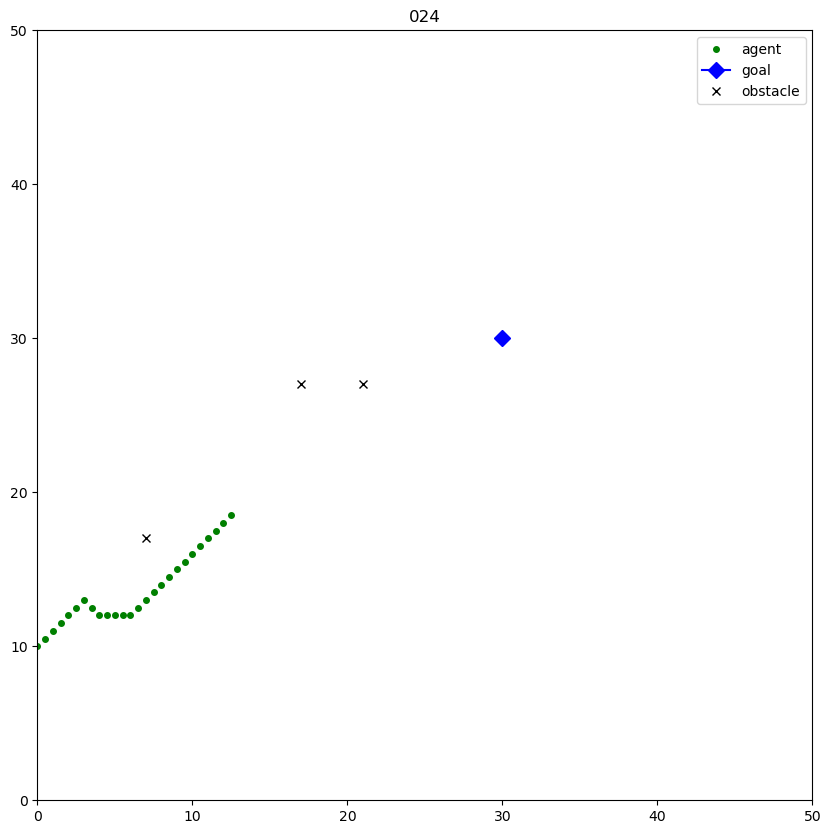

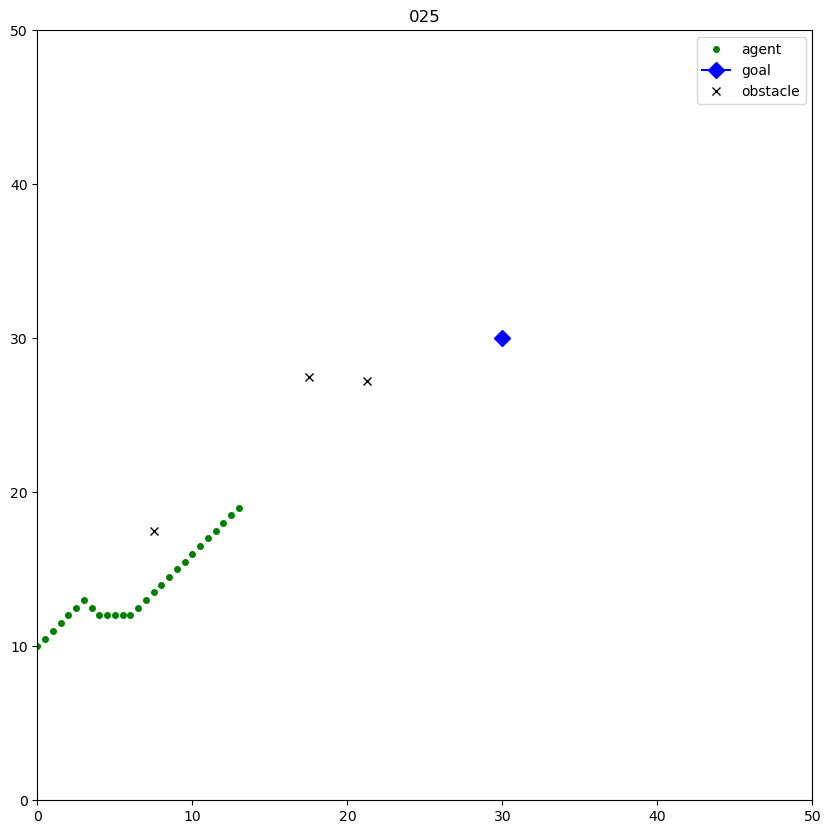

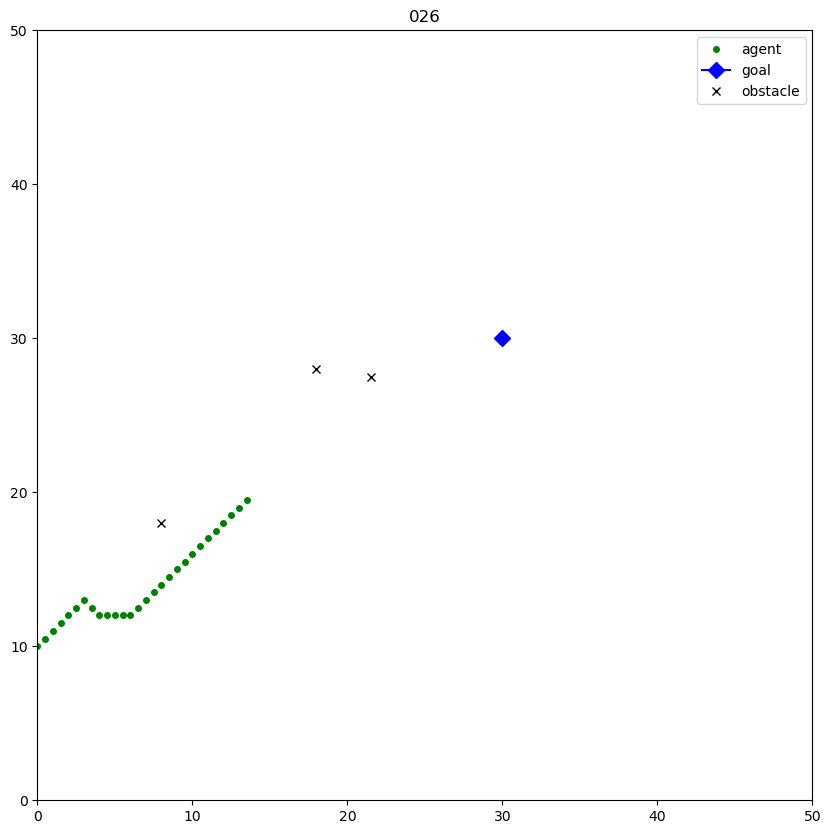

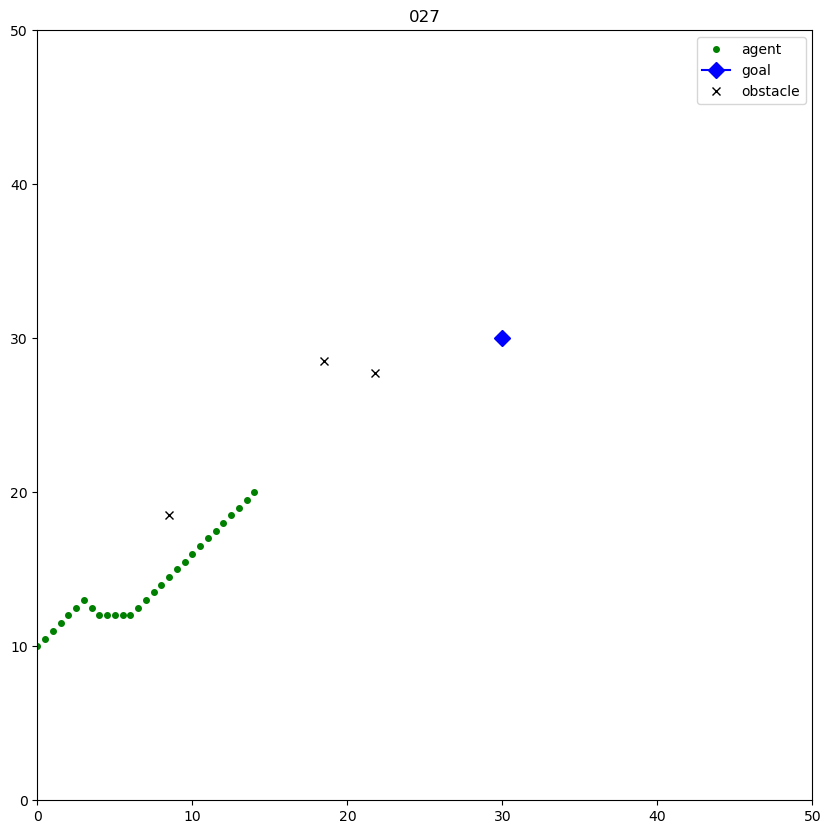

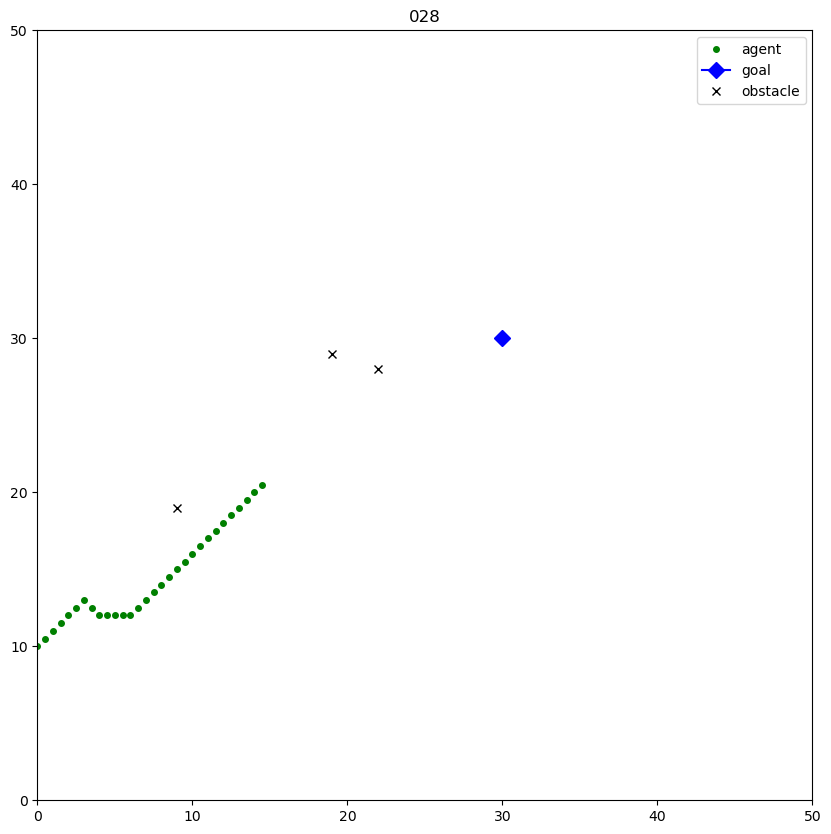

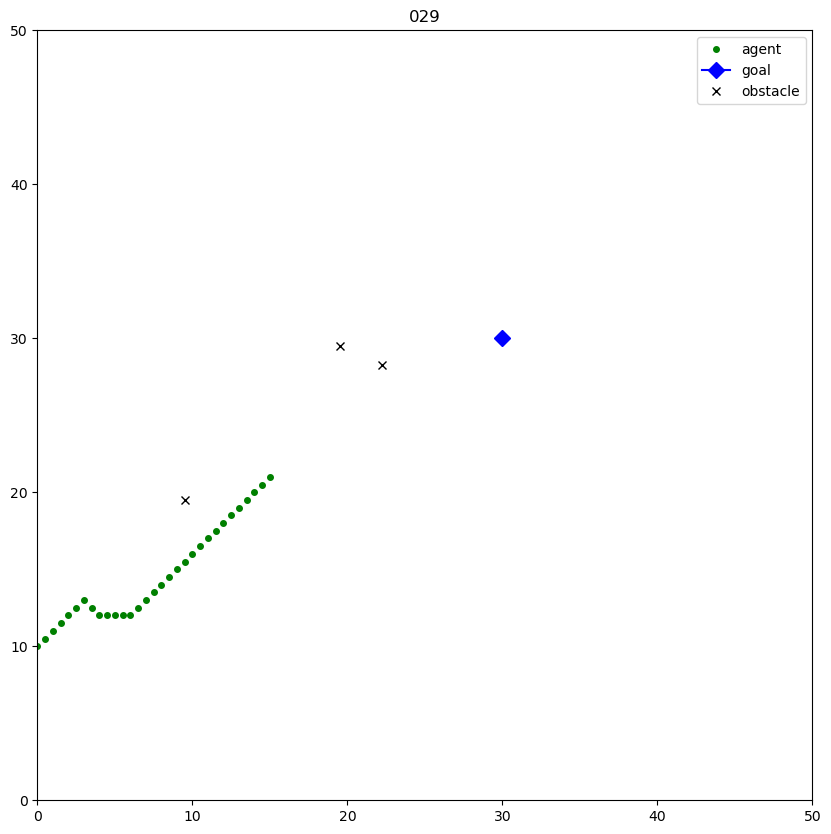

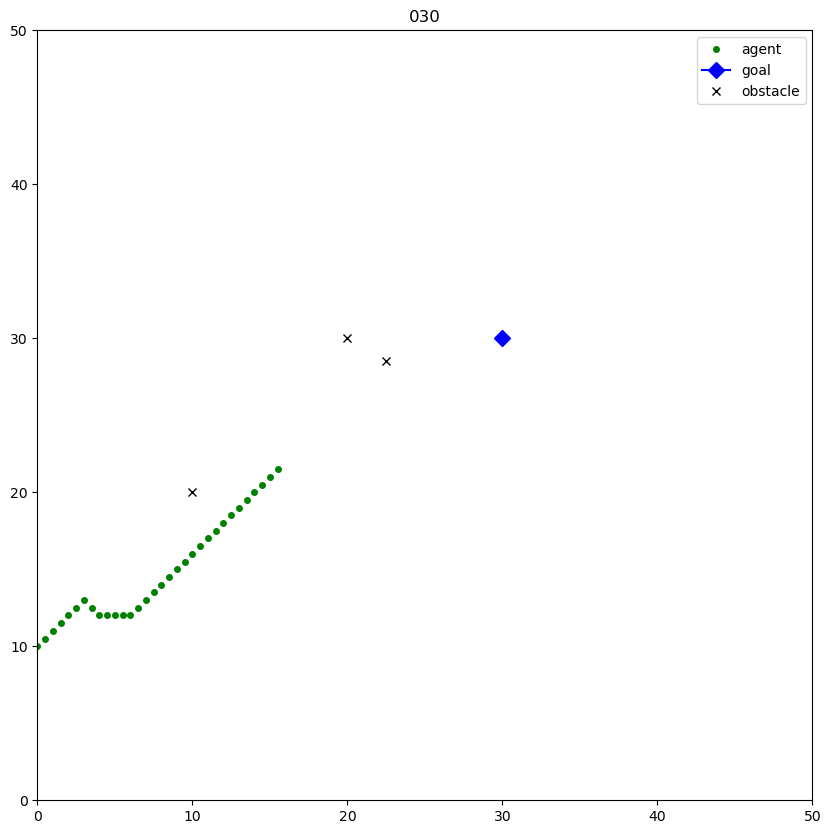

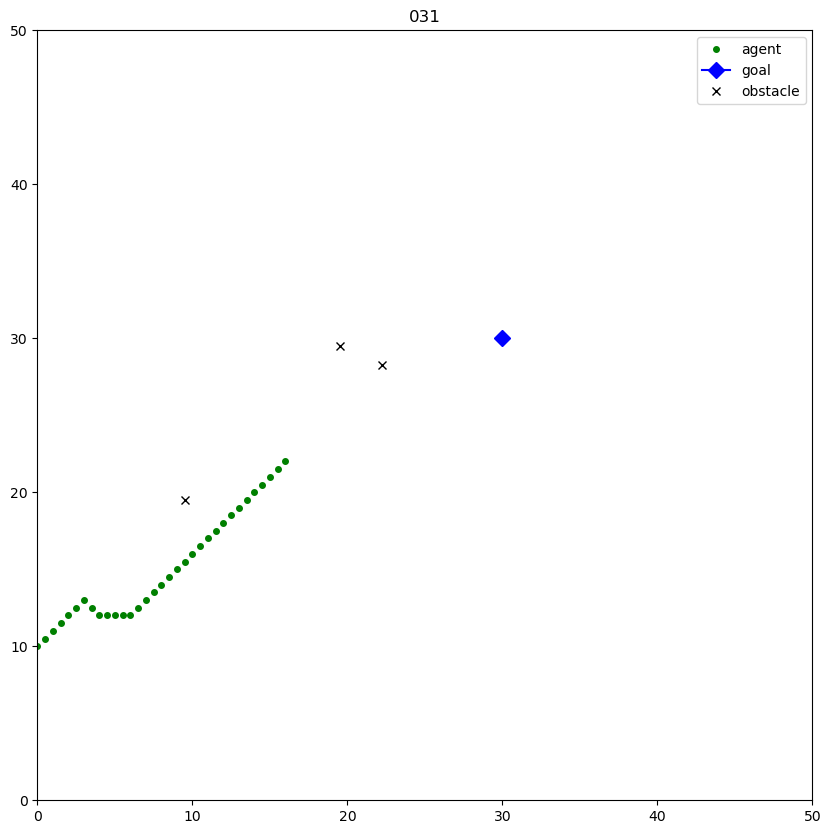

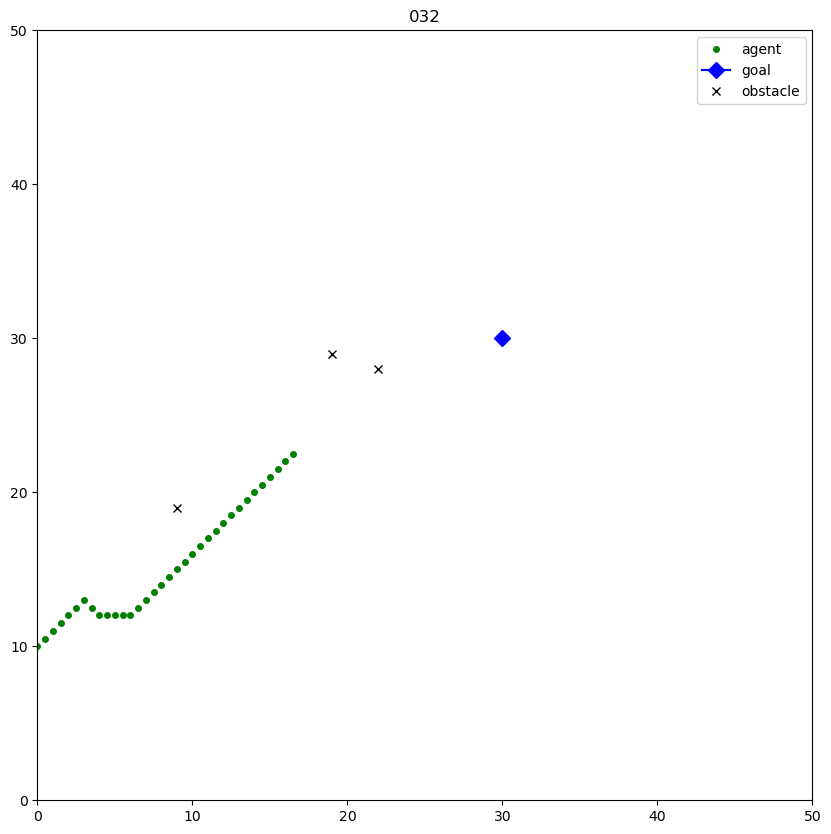

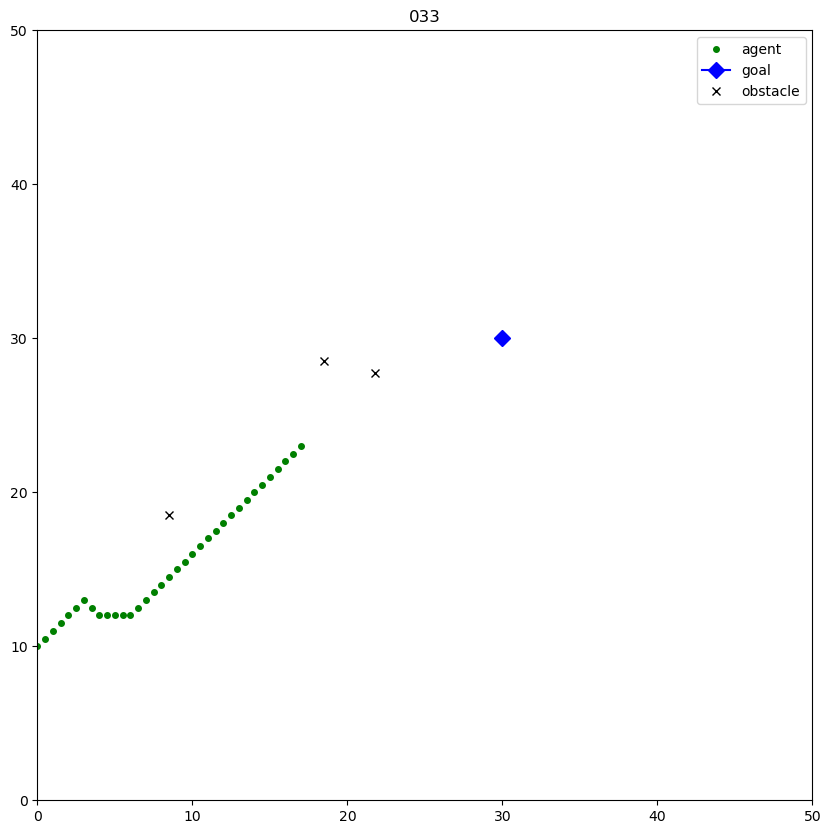

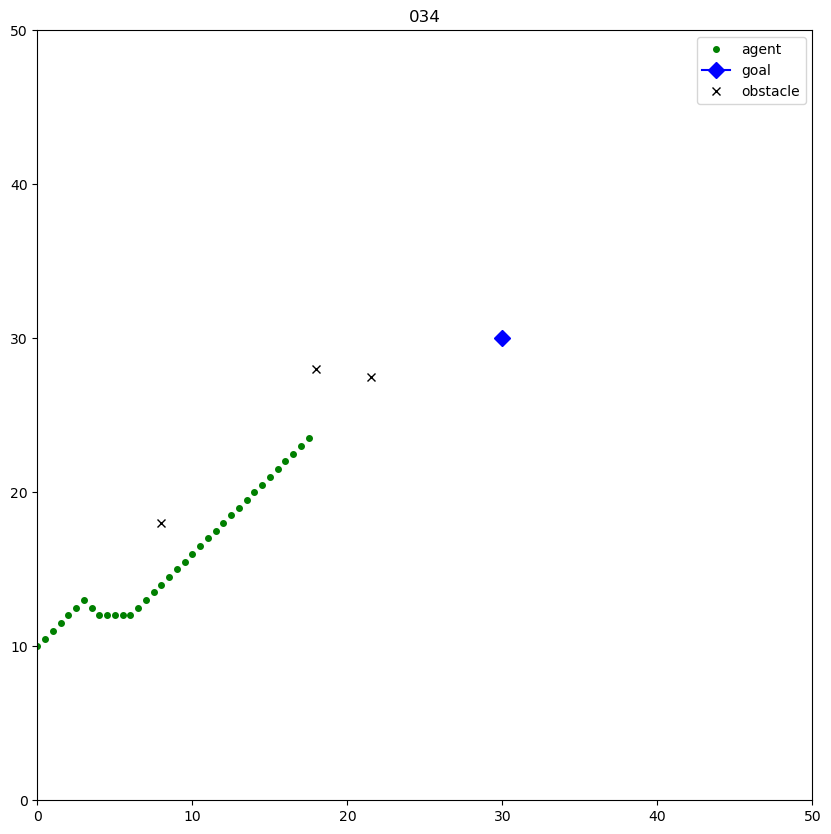

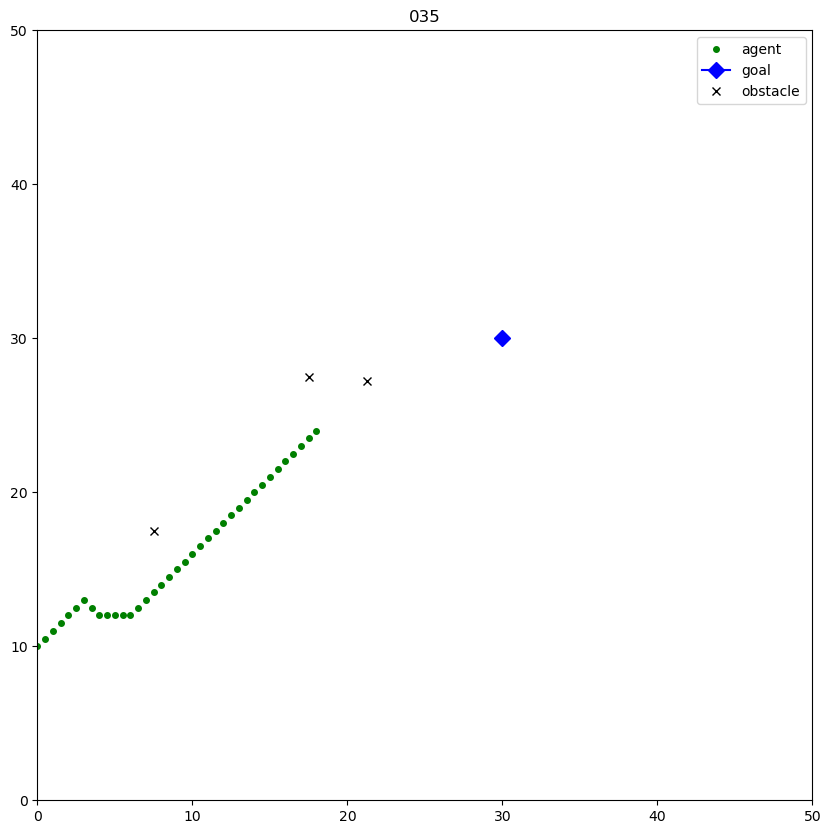

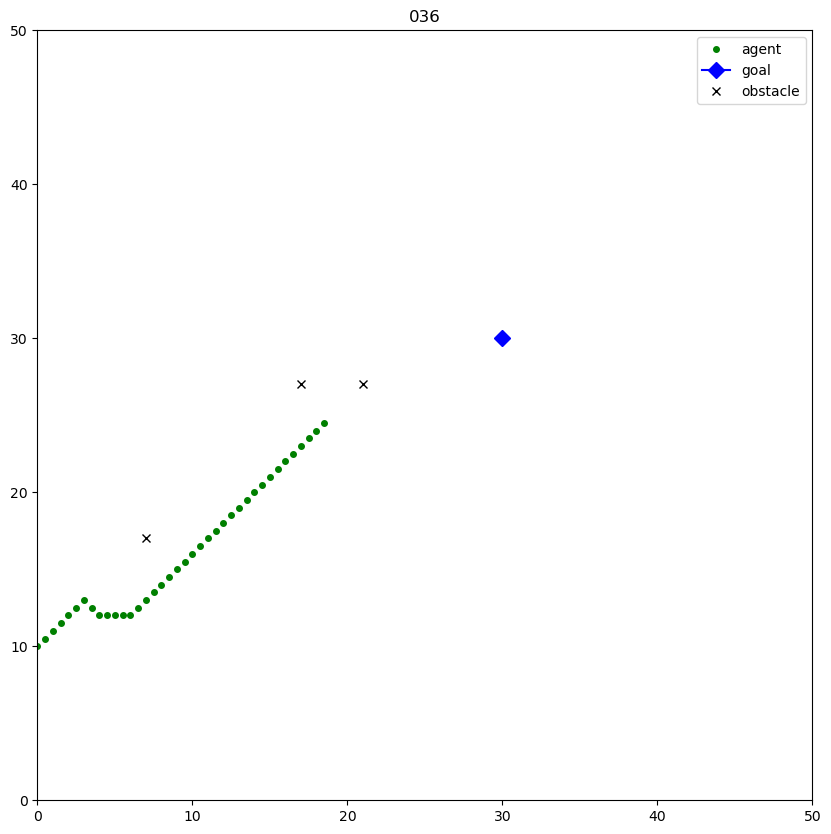

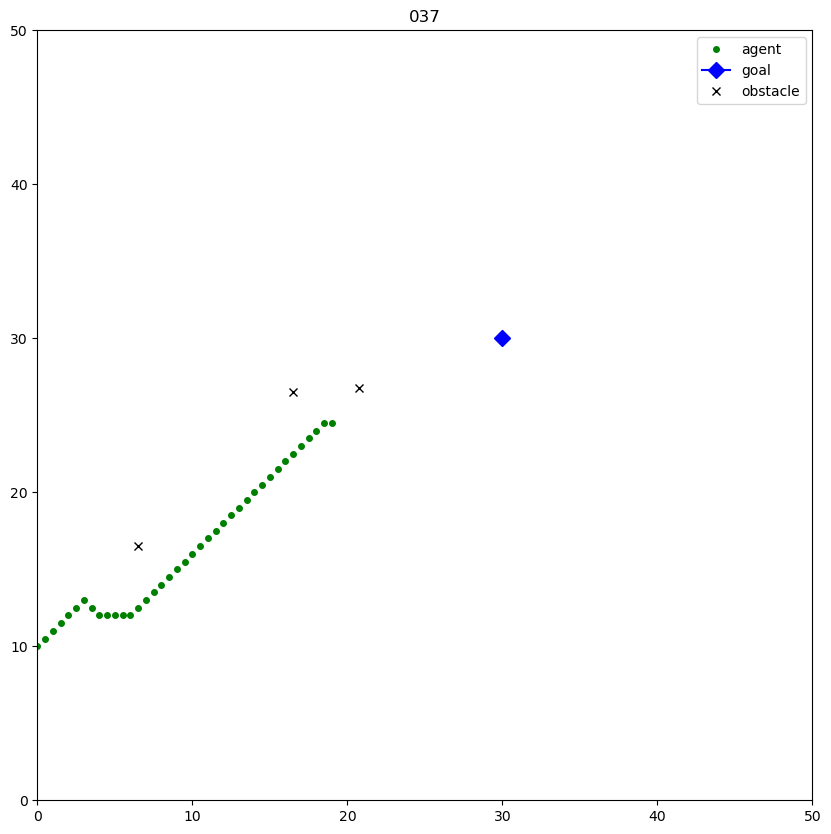

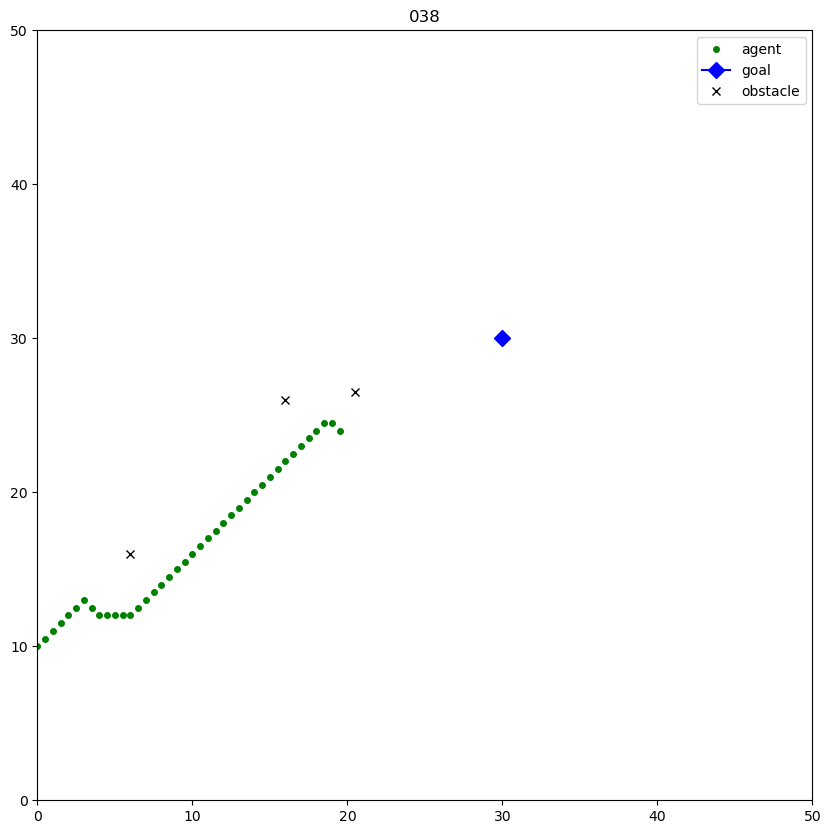

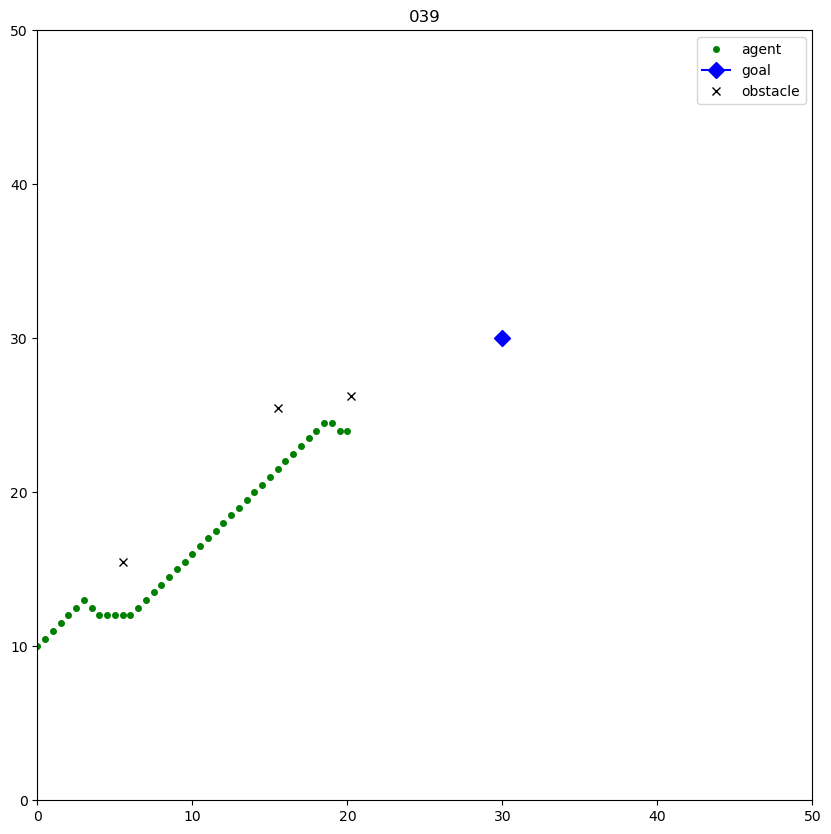

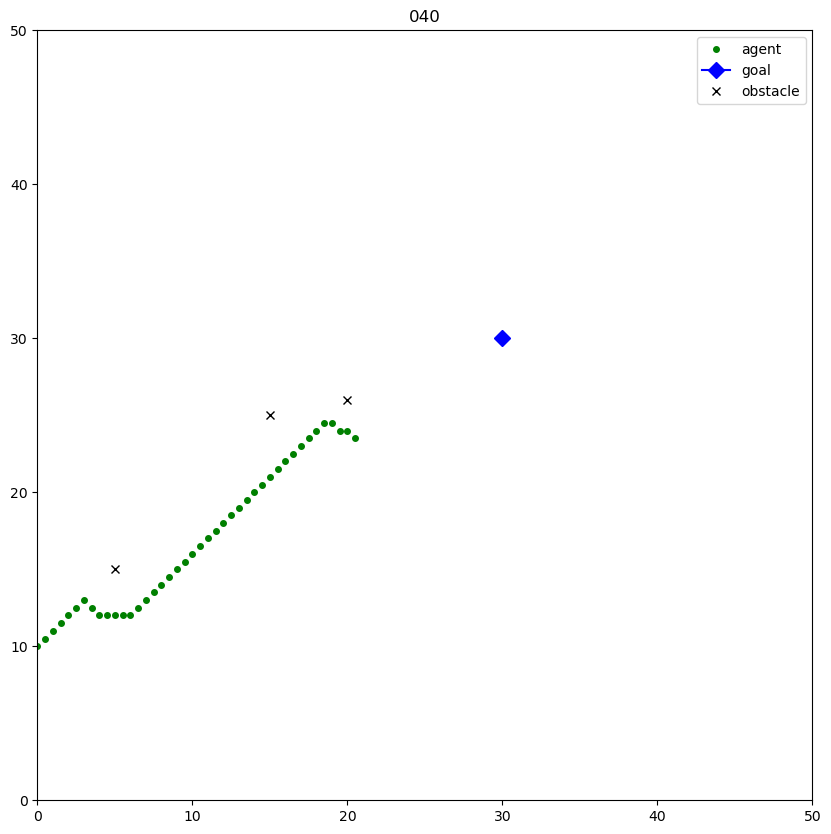

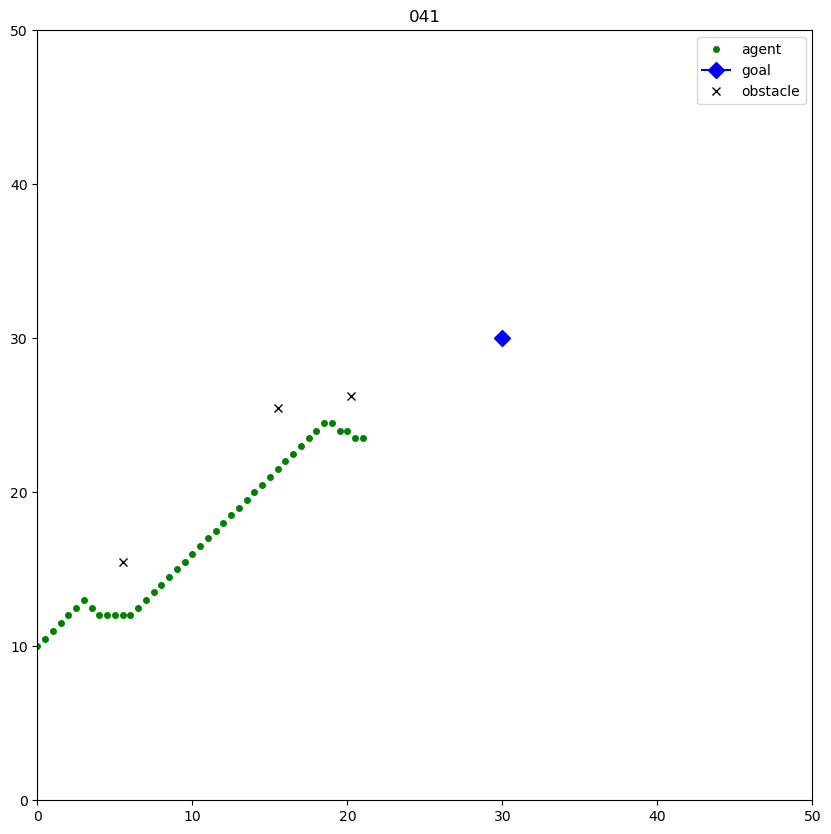

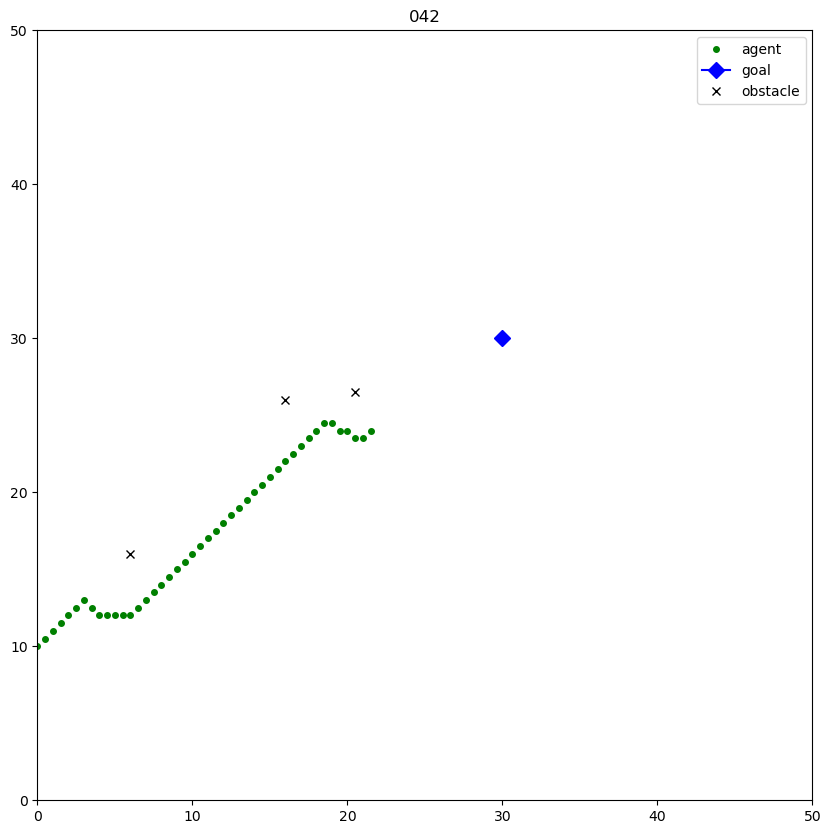

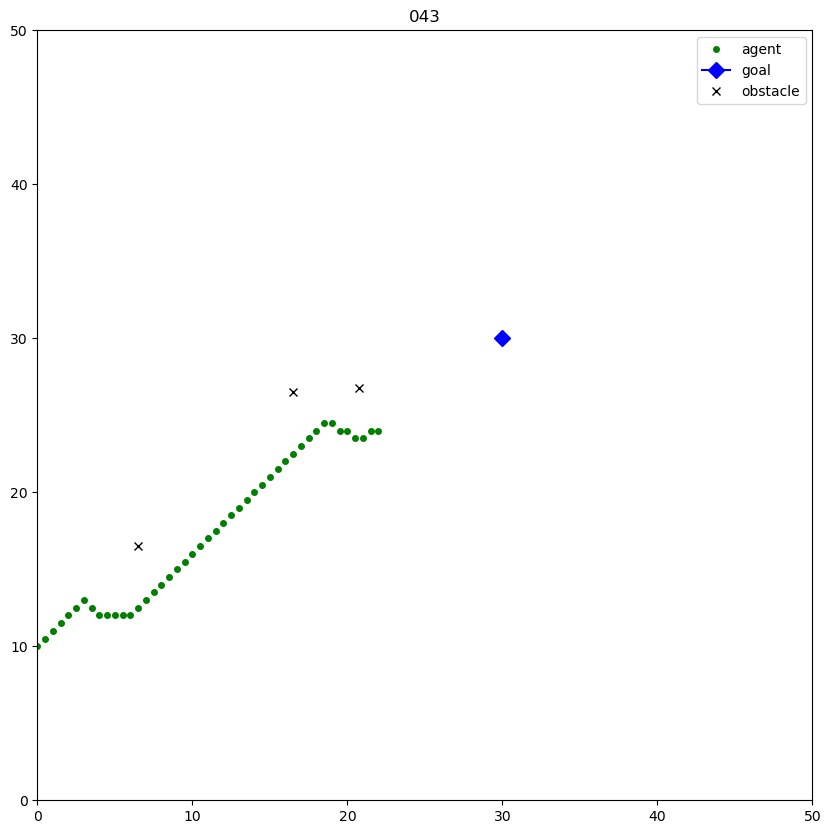

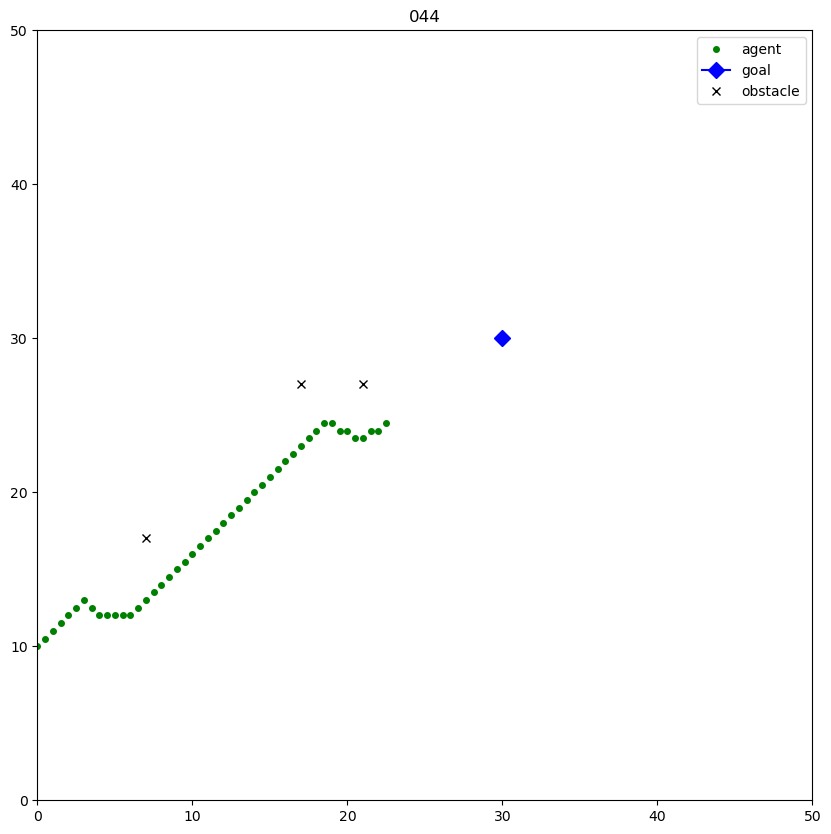

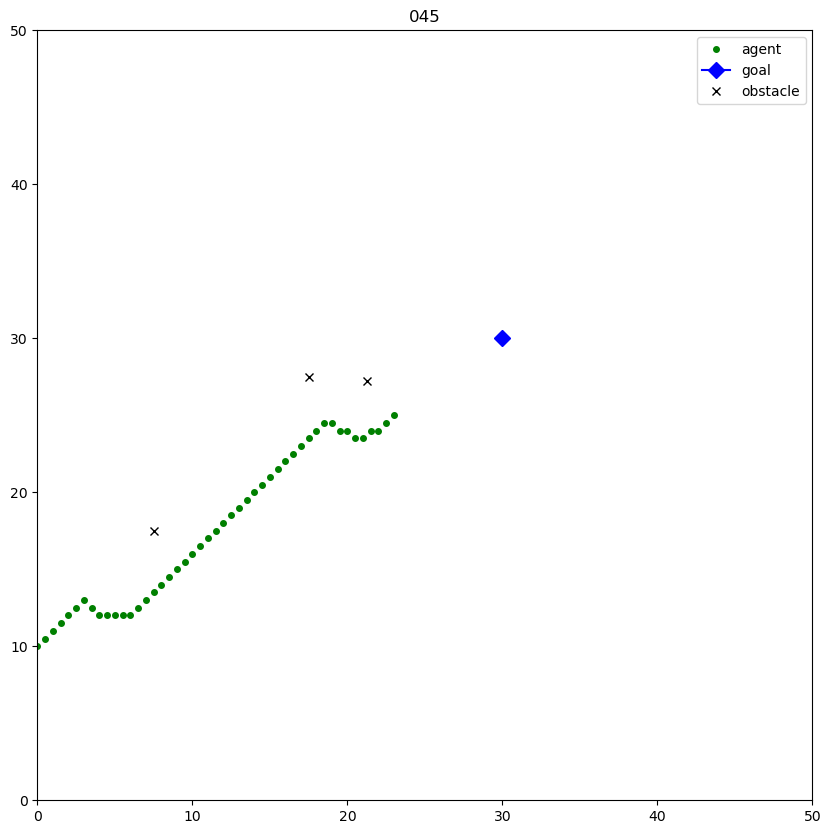

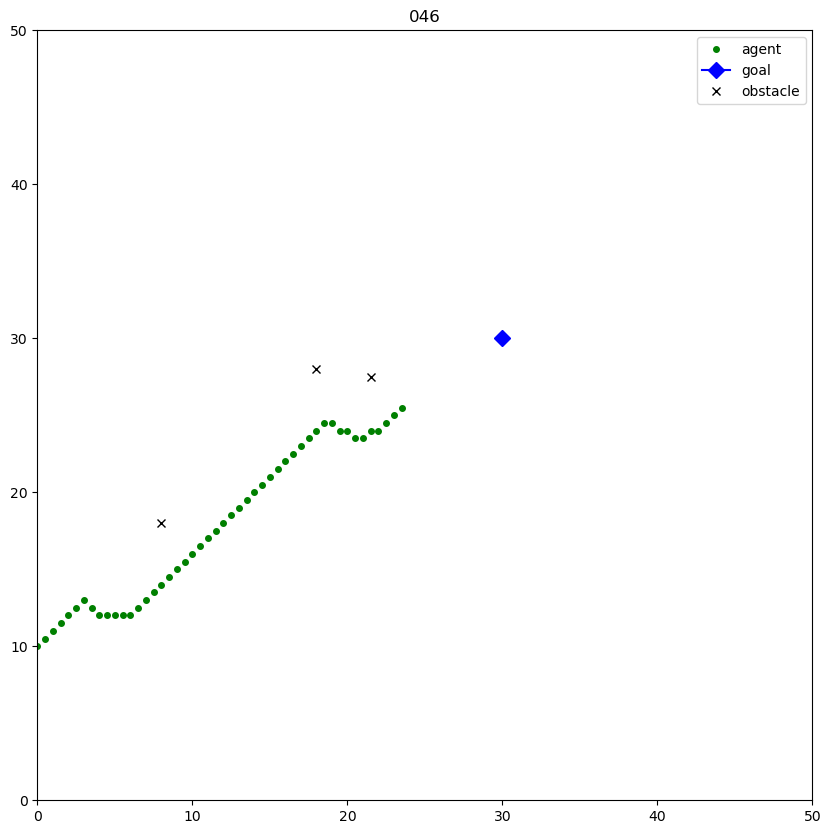

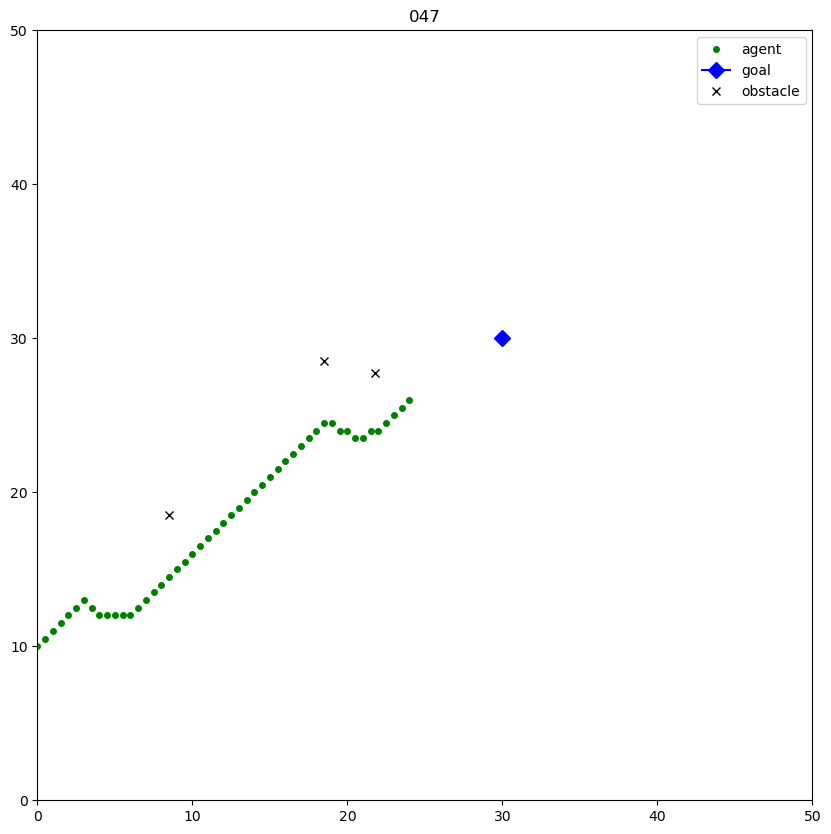

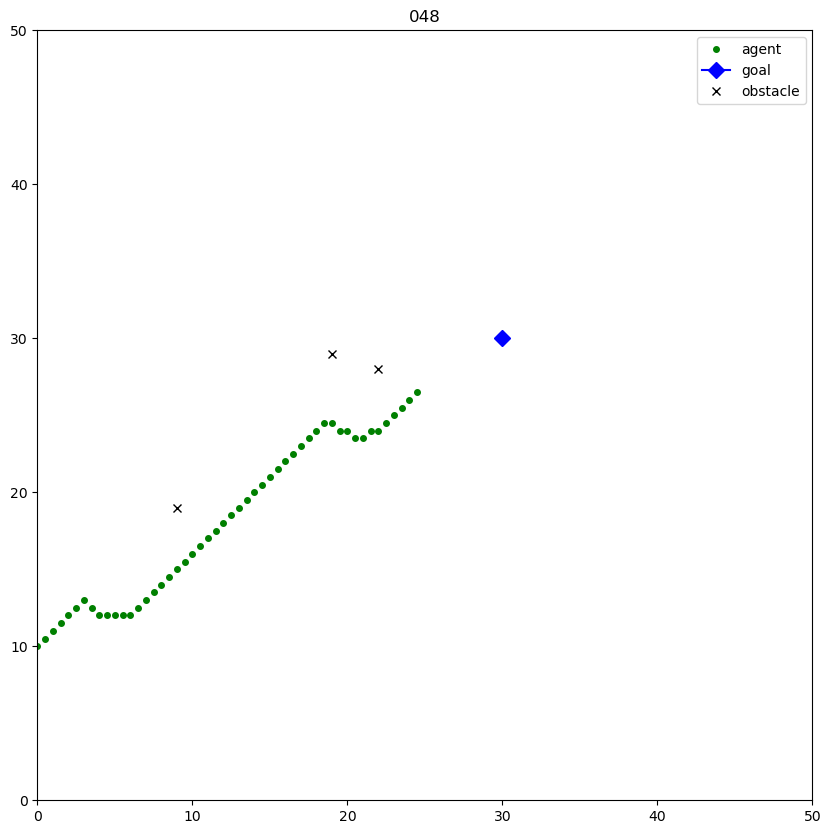

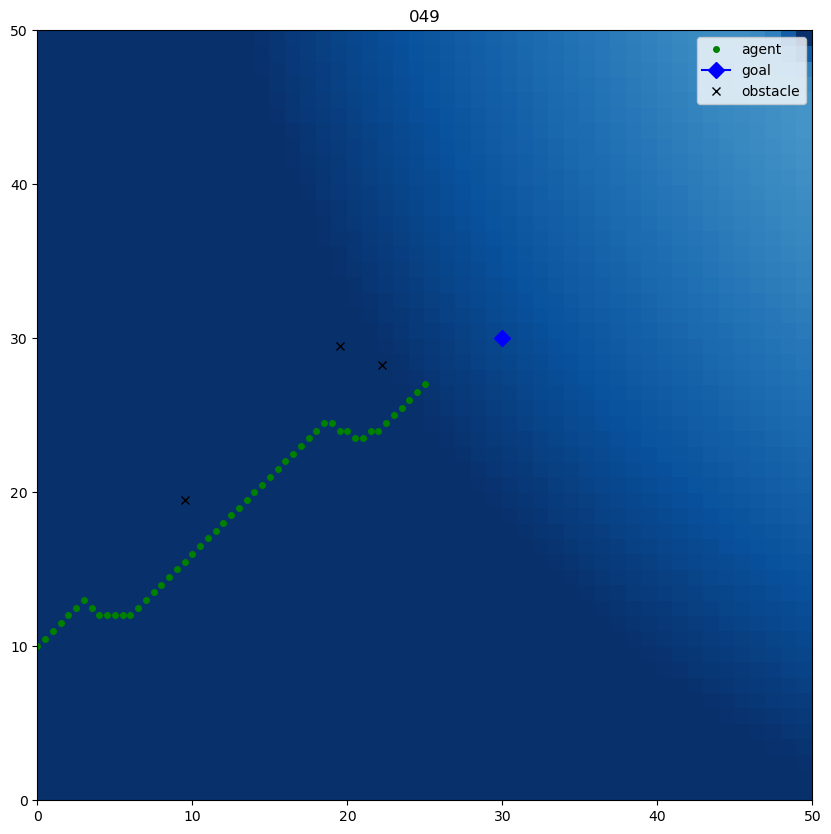

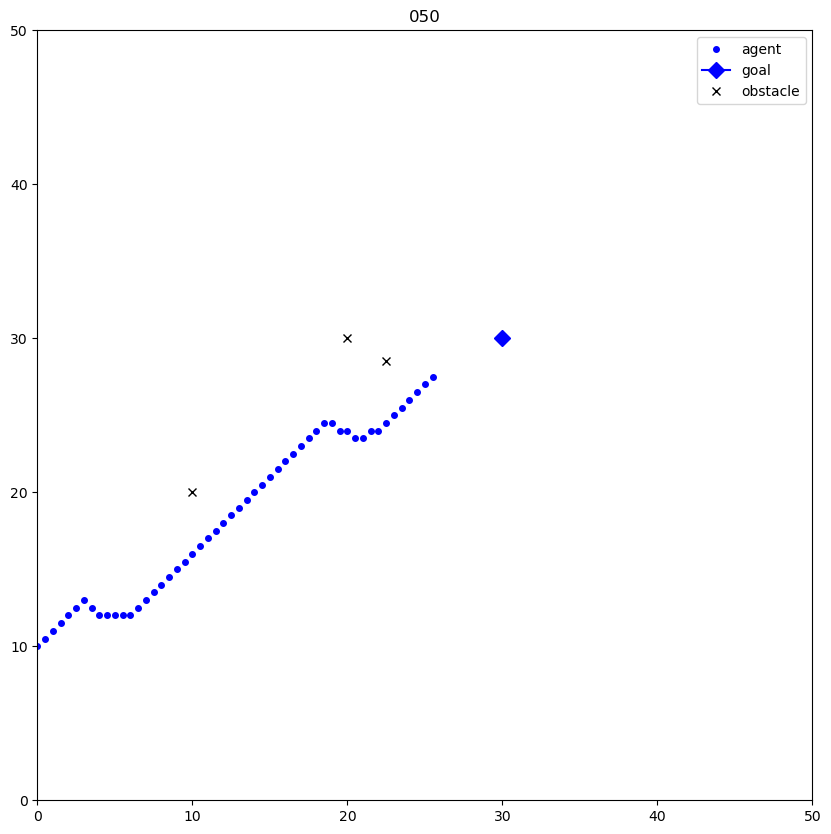

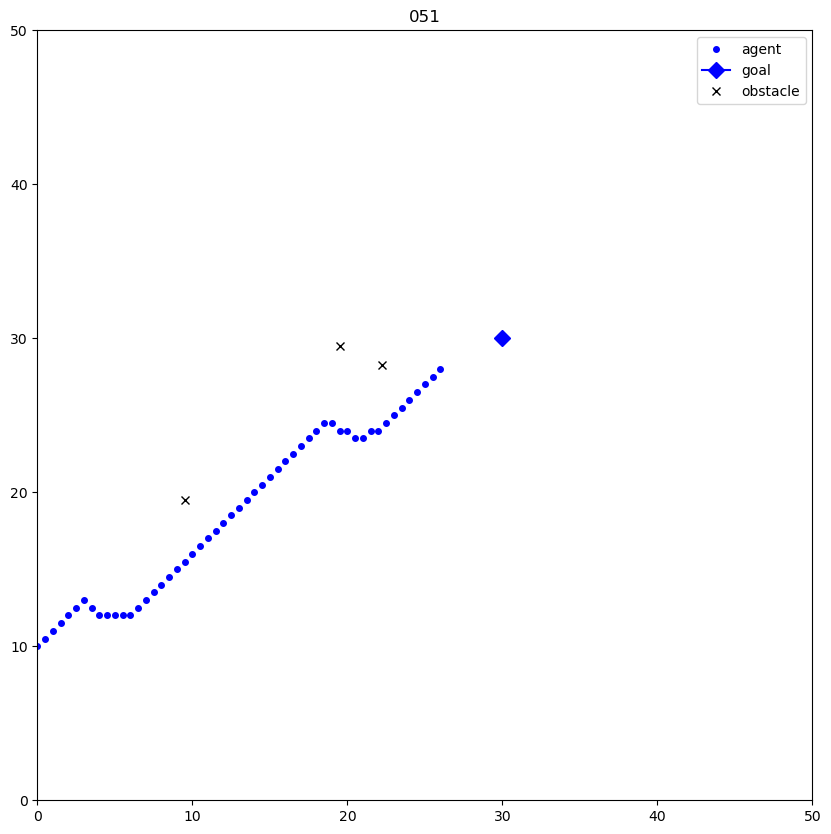

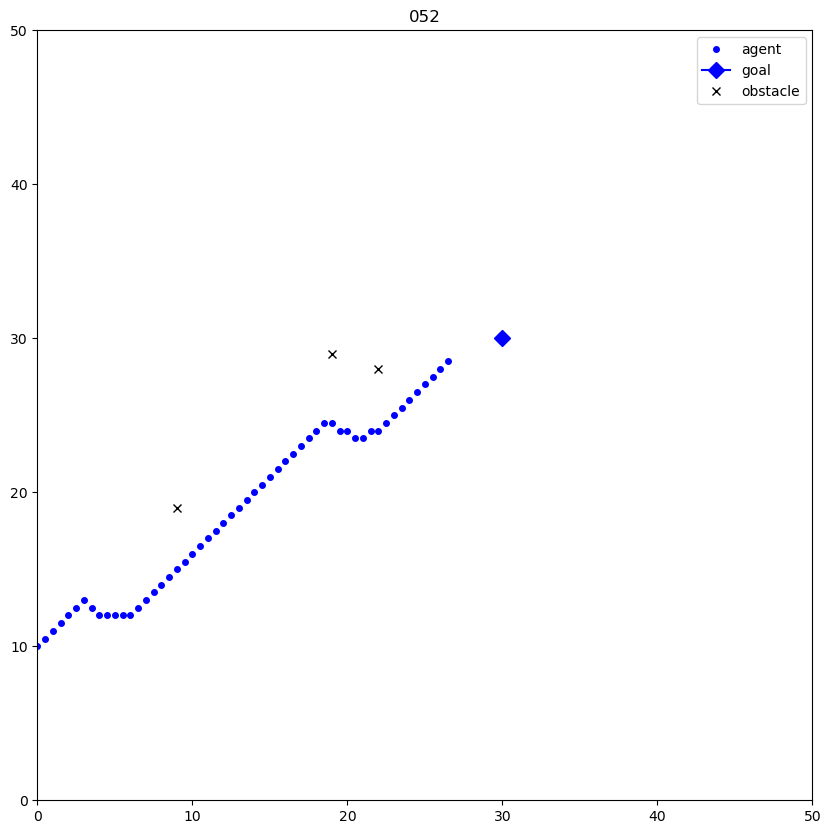

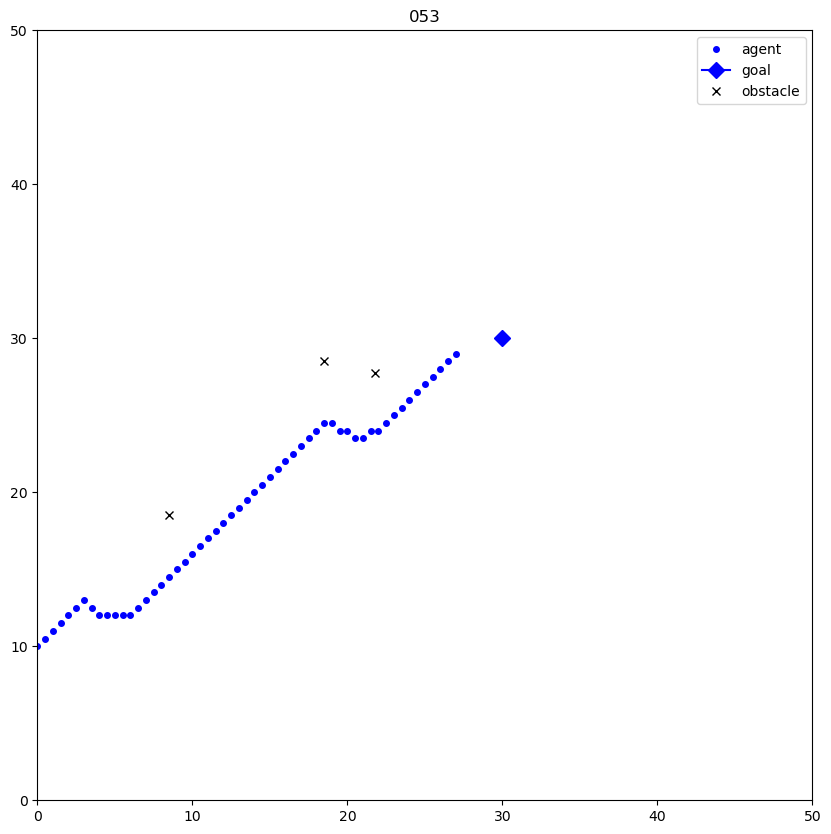

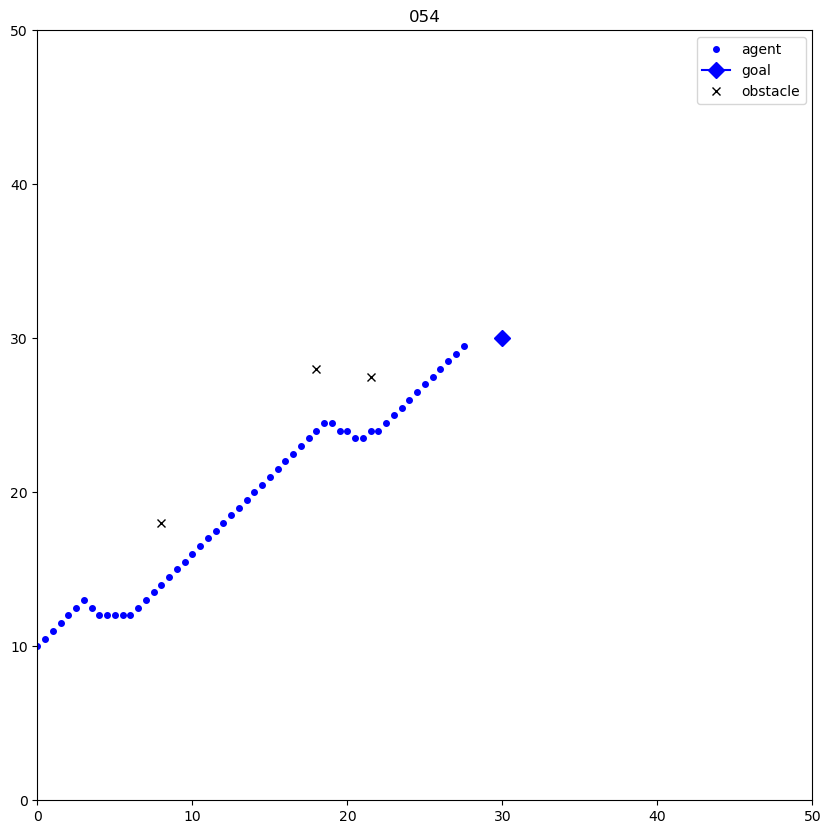

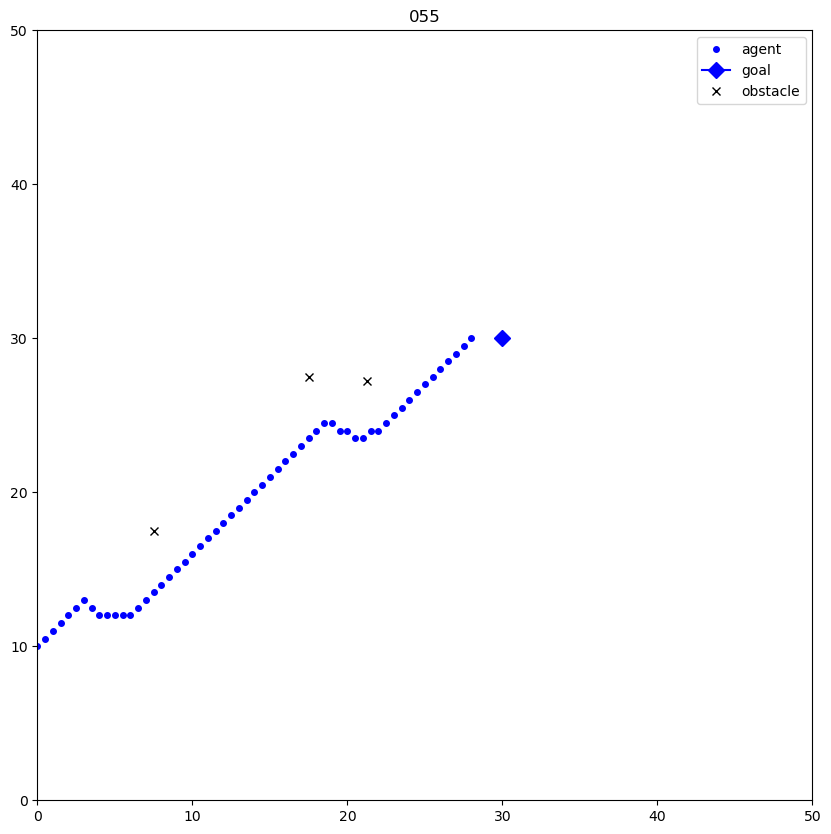

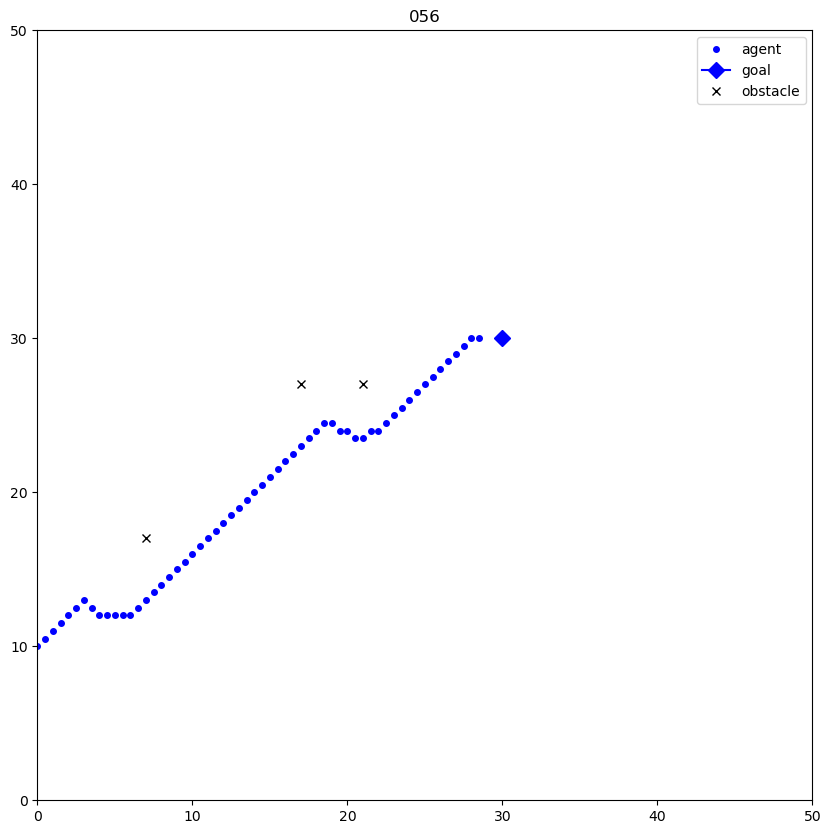

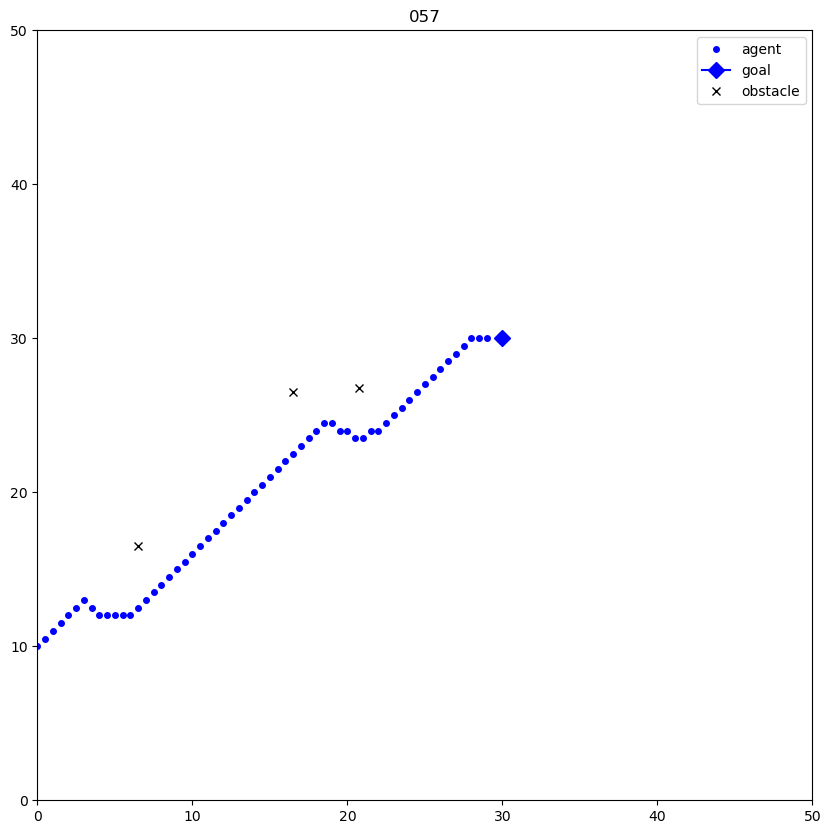

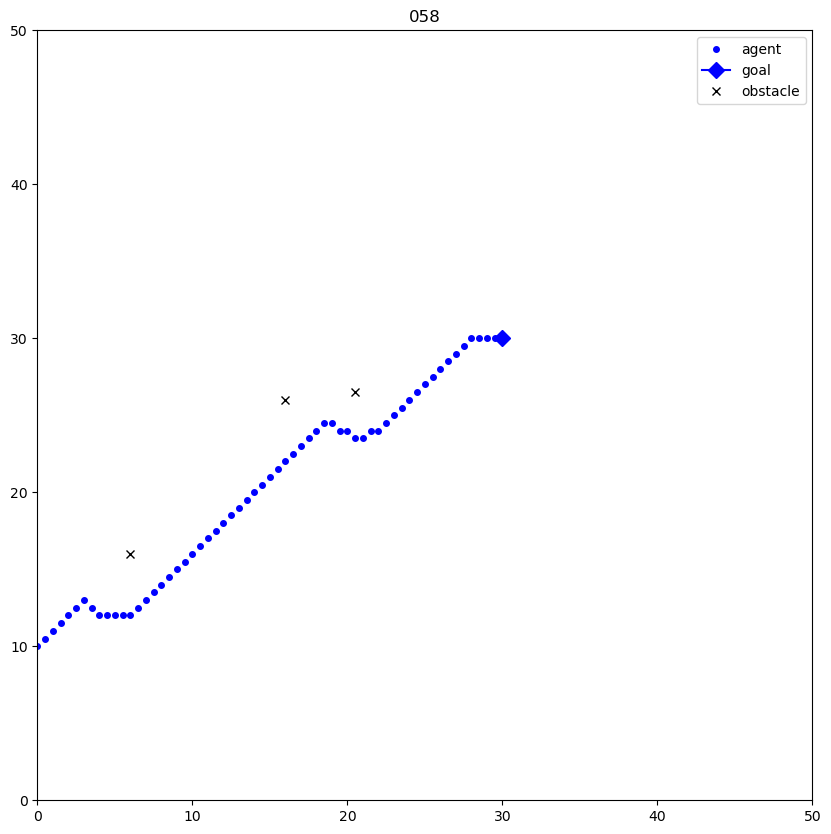

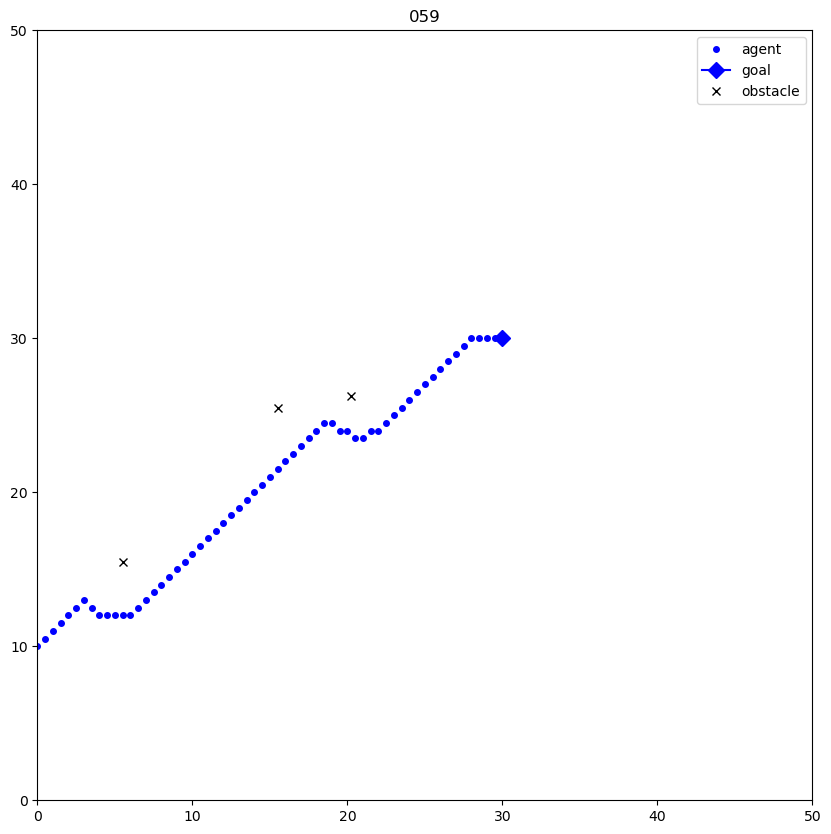

In [17]:
saveDir = r"C:\Users\kawaw\master\Catching\robotControl\APFM\fig_dynamic"
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
main(saveDir=saveDir)

# Make video

In [18]:
import glob

import cv2
import os
import re


class MakeVideo:
    def __init__(self, src, videoname):
        self.src = src
        self.videoname = videoname
        self.main()

    def atoi(self, text):
        return int(text) if text.isdigit() else text

    def natural_keys(self, text):
        return [self.atoi(c) for c in re.split(r"(\d+)", text)]

    def main(self):
        img_array = []
        for filename in sorted(glob.glob(f"{self.src}/*.jpg"), key=self.natural_keys):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            img_array.append(img)
        size = (width, height)
        out = cv2.VideoWriter(
            self.videoname, cv2.VideoWriter_fourcc(*"mp4v"), 3.0, size
        )

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [19]:
src = r"C:\Users\kawaw\master\Catching\robotControl\APFM\fig_dynamic"
videoname = r"C:\Users\kawaw\master\Catching\robotControl\APFM\pathPlanning_dynamic.mp4"
mkVideo = MakeVideo(src=src, videoname=videoname)